In [1]:
import json
import numpy as np
import csv
import scipy.stats.distributions
from scipy.spatial.transform import Rotation
import os
from matplotlib import pyplot as plt
import random
import math
import cvxpy as cp
import csv

# Helper Functions

### DIspersion filter

In [2]:
def dispersion_filtering(x, y, dispersion_threshold = 6, duraiton_threshold=0.2):
    start = 0
    window = []
    if len(x) == 0:
        return [], []
    fps = int(np.round(1/(x[1] - x[0])))
    duration_threshold_frames = np.ceil(duraiton_threshold * fps)
    
    def dispersion(arr):
        # input is a 2d array
        disp = np.max(arr[:, 0]) - np.min(arr[:, 0]) + np.max(arr[:, 1]) - np.min(arr[:, 1])
        return disp

    fixations = []
    fixations_intervals = []
    
    # while there are still points
    while int(start+duration_threshold_frames) < y.shape[0]:
        # initialize a window:
        window = list(range(int(start), int(start+duration_threshold_frames)))
        start = start + duration_threshold_frames
        disp = dispersion(y[window])
        # while the dispersion is less than the threshold
        while disp <= dispersion_threshold:
            if window[-1]+1 < y.shape[0]:
                window.append(window[-1]+1)
            start = start + 1
            if start >= y.shape[0]:
                break
            disp = dispersion(y[window])

        # if the current set of points never fit the duration criteria
        if len(window) <= duration_threshold_frames:
            start = start + 1
        # otherwise note it as fixations
        else:
            centroid = np.mean(y[window], axis=0)
            duration = (window[-1] - window[0]) / fps
            fixations.append([centroid[0], centroid[1], duration])
            fixations_intervals.append([window[0], window[-1]])
    fixations = np.array(fixations)
    return fixations, fixations_intervals


### Find Head Angle

In [3]:
def get_head_angles(head_dir, target_dir, target_fixations_intervals, target_fixation_duration, persistant_target_angle = 0):
    # find the head fixations that are within the target fixations
    head_fixation_final_val = []
    head_fixations_closest_val = []
    head_fixations_extreme_val = [] # not being used
    head_fixations_value_held = [] # not being used 
    head_fixations_value_held_isValid = [] # not being used
    # find a few head fixations that are within the target fixations
    non_zero_fixation_angles = []
    non_zero_fixation_duration = []
    # find a few head fixations that are within the target fixations
    for i in range(0, len(target_fixations_intervals)):
        angle = target_dir[target_fixations_intervals[i][0]:target_fixations_intervals[i][1], 2].mean()
        if np.abs(angle - persistant_target_angle) > 0:
            non_zero_fixation_angles.append(angle) # this only record non-zero angles
            non_zero_fixation_duration.append(target_fixation_duration[i])
            target_interval = target_fixations_intervals[i]
            start = target_interval[0]
            end = target_interval[1]
            ################# find the head intervals that starts within the target interval, and use average as angle of the head #################
            # intersected = []
            # for j in range(0, len(head_fixations_intervals)):
            #     if head_fixations_intervals[j][0] >= start and head_fixations_intervals[j][0] <= end:
            #         intersected.append(j)
            # # the fixation interval closest to the target interval is selected
            # closest_angle = 10000000
            # closest_index = -100
            # if len(intersected) > 0:
            #     for j in intersected:
            #         head_fixation_value = head_dir[head_fixations_intervals[j][0]:head_fixations_intervals[j][1]][:, 2].mean()
            #         target_angle = target_dir[target_fixations_intervals[i][0]:target_fixations_intervals[i][1]][:, 2].mean()
            #         if np.abs(head_fixation_value - target_angle) < closest_angle:
            #             closest_angle = np.abs(head_fixation_value - target_angle)
            #             closest_index = j
            #     head_fixations_value_held.append(head_dir[head_fixations_intervals[closest_index][0]:head_fixations_intervals[closest_index][1]][:, 2].mean())
            #     head_fixations_value_held_isValid.append(True)
            # else:
            #     head_fixations_value_held.append(head_dir[target_fixations_intervals[i][0]:target_fixations_intervals[i][1]][:, 2].mean())
            #     head_fixations_value_held_isValid.append(False)
            
            ################# find the closest value within the target interval #################
            extreme_value_index = np.argmin(np.abs(head_dir[start:end][:, 2] - angle))
            head_fixations_closest_val.append(head_dir[start:end][:, 2][extreme_value_index])
            # if head_fixations_closest_val[-1] / target_dir[start:end][:, 2].mean() < 0:
            #     print("wrong sign")
            #     continue

            ################# find the extreme value within the target interval #################
            extreme_value_index = np.argmax(np.abs(head_dir[start:end][:, 2]))
            head_fixations_extreme_val.append(head_dir[start:end][:, 2][extreme_value_index])

            ################# find the final value within target interval #################
            head_fixation_final_val.append(head_dir[end][2])
            # plt.plot(head_dir[start:end][:, 0], head_dir[start:end][:, 2], label="head")
            # plt.plot(target_dir[start:end][:, 0], target_dir[start:end][:, 2], label="target")
            # plt.plot(head_dir[start:end][:, 0], np.ones(head_dir[start:end][:, 0].shape) * head_fixations_extreme_val[-1], label="head fixation (from extreme value method)")
            # plt.plot(head_dir[start:end][:, 0], np.ones(head_dir[start:end][:, 0].shape) * head_fixations_value_held[-1], label="head fixation (from value held method)")
            # plt.plot(head_dir[start:end][:, 0], np.ones(head_dir[start:end][:, 0].shape) * head_fixations_closest_val[-1], label="head fixation (from closest value method)")
            # plt.plot(head_dir[start:end][:, 0], np.ones(head_dir[start:end][:, 0].shape) * head_fixation_final_val[-1], label="head fixation (from final value method)")
          
            # plt.legend()
            # plt.show()
        else:
            head_fixations_closest_val.append(persistant_target_angle)
            head_fixations_extreme_val.append(persistant_target_angle)
            head_fixations_value_held.append(persistant_target_angle)
            head_fixations_value_held_isValid.append(False)
            non_zero_fixation_angles.append(persistant_target_angle)
            non_zero_fixation_duration.append(persistant_target_angle)
    
    head_fixations_closest_val = np.array(head_fixations_closest_val)
    head_fixations_extreme_val = np.array(head_fixations_extreme_val)
    head_fixations_value_held = np.array(head_fixations_value_held)
    head_fixations_value_held_isValid = np.array(head_fixations_value_held_isValid)
    head_fixation_final_val = np.array(head_fixation_final_val)
    non_zero_fixation_angles = np.array(non_zero_fixation_angles)
    non_zero_fixation_duration = np.array(non_zero_fixation_duration)
    
    return head_fixations_closest_val, non_zero_fixation_angles, non_zero_fixation_duration

        



### find CHOR

In [4]:
class GaussianKernal:
    def __init__(self, loc, sigma, amplitude):
        self.sigma = sigma
        self.loc = loc
        self.amplitude = amplitude
        self.gaussina = scipy.stats.distributions.norm(loc, sigma)
    def cumulate(self, t_arr, x_arr):
        # t_arr is the time array
        # x_arr is the value array, in which we will cumulate a series of GaussianKernals
        x_arr += self.amplitude * self.gaussina.pdf(t_arr)
        return x_arr

def generate_smooth_distribution(fixation_angles):
    # generate a smooth distribution of the fixation ang
    kernal_list = []
    kernal_std = 3
    kernal_amplitude = 1
    for i in range(len(fixation_angles)):
        kernal_list.append(GaussianKernal(fixation_angles[i], kernal_std, kernal_amplitude))
    t_arr = np.linspace(-100, 100, 1000)
    x_arr = np.zeros(t_arr.shape)
    for kernal in kernal_list:
        x_arr = kernal.cumulate(t_arr, x_arr)
    x_arr = x_arr/np.sum(x_arr)
    return t_arr, x_arr, kernal_list
def generate_CHOR_distribution(head_angles, target_angles, target_angle_distribution):
    # find the closest angle in the target angle distribution for each head angle
    head_kernal_list = []
    for i in range(len(target_angles)):
        closest_target_angle_index = np.argmin(np.abs(target_angle_distribution[0] - target_angles[i]))
        # scaling the amplitude of each head angle by the corresponding target angle distribution
        head_kernal_list.append(GaussianKernal(head_angles[i], 3, 1 / target_angle_distribution[1][closest_target_angle_index]))
    t_arr = np.linspace(-100, 100, 1000)
    x_arr = np.zeros(t_arr.shape)
    for kernal in head_kernal_list:
        x_arr = kernal.cumulate(t_arr, x_arr)
    x_arr = x_arr/np.sum(x_arr)
    # find start and end range that contains 90% of the distribution
    cumulative_x_arr = np.cumsum(x_arr)
    start_index = np.argmin(np.abs(cumulative_x_arr - 0.05))
    end_index = np.argmin(np.abs(cumulative_x_arr - 0.95))
    start_angle = t_arr[start_index]
    end_angle = t_arr[end_index]

    return t_arr, x_arr, start_angle, end_angle
def get_CHOR(fixation_angles, head_fixation_angles, angle_to_ignore=0):
    is_not_zero = np.where(np.abs(fixation_angles-angle_to_ignore) <= 1E-3, False, True)
    target_angle_distribution = generate_smooth_distribution(fixation_angles[is_not_zero])
    head_angle_distribution = generate_CHOR_distribution(head_fixation_angles[is_not_zero], fixation_angles[is_not_zero], target_angle_distribution)
    CHOR_start, CHOR_end = head_angle_distribution[2], head_angle_distribution[3]
    return CHOR_start, CHOR_end, target_angle_distribution, head_angle_distribution



In [5]:
def align_target_and_results(collected_gaze, collected_duration, target_gaze, target_duration):
    deletion_index = -1
    for i in range(0, len(target_duration)):
        if np.abs(collected_gaze[i] - target_gaze[i]) > 1E-3:
            deletion_index = i
            break

    if deletion_index < 0:
        return target_gaze, target_duration
    else:
        new_target_gaze = np.concatenate([target_gaze[0:deletion_index], target_gaze[deletion_index+1:]])
        new_target_duration = np.concatenate([target_duration[0:deletion_index], target_duration[deletion_index+1:]])
        return new_target_gaze, new_target_duration

# Analyze The data For the onward experiment

In [14]:
input_dirs = ["/Users/evanpan/Desktop/Experiment_related_files/recordings/TEST_REPEATED_CONTINIOUS_DWELL_PILOT_YIMA_FUTURE_CONDITIONS/collectedData",
              "/Users/evanpan/Desktop/Experiment_related_files/recordings/TEST_REPEATED_CONTINIOUS_DWELL_PILOT_DADA_FUTURE_CONDITIONS/collectedData",
              "/Users/evanpan/Desktop/Experiment_related_files/recordings/TEST_REPEATED_CONTINIOUS_DWELL_PILOT_EVAN_FUTURE_CONDITIONS/collectedData",
              ]
all_eye_data = []
all_head_data = []
all_target_data = []
all_target_input = []
for input_dir in input_dirs:
    dirs = os.listdir(input_dir)
    recording_file_names = ['onward_condition_pilot']
    data_types = ["gaze_dir", "head_dir", "head_pos", "target_pos"]
    # get duration of each trial:
    total_length = 0

    for fileName in recording_file_names:
        data_type = "gaze_dir"
        fullPath = os.path.join(input_dir, data_type + "_" + fileName + ".csv")
        eye_data = np.genfromtxt(fullPath, delimiter=',', dtype=float)
        
        data_type = "head_dir"
        fullPath = os.path.join(input_dir, data_type + "_" + fileName + ".csv")
        head_data = np.genfromtxt(fullPath, delimiter=',', dtype=float)
        
        data_type = "target_pos"
        fullPath = os.path.join(input_dir, data_type + "_" + fileName + ".csv")
        target_data = np.genfromtxt(fullPath, delimiter=',', dtype=float)
        
        all_eye_data.append(eye_data)
        all_head_data.append(head_data)
        all_target_data.append(target_data)
        
        setupFileName = os.path.join(*[input_dir, fileName+".json"])
        target_input = json.load(open(setupFileName, "r"))
        all_target_input.append(target_input)

In [15]:
controlled_trial_eye_data = []
controlled_trial_head_data = []
controlled_trial_target_data = []
controlled_trial_target_input = []
for input_dir in input_dirs:
    dirs = os.listdir(input_dir)
    recording_file_names = ['onward_condition_pilot_primer']
    data_types = ["gaze_dir", "head_dir", "head_pos", "target_pos"]
    # get duration of each trial:
    total_length = 0

    for fileName in recording_file_names:
        data_type = "gaze_dir"
        fullPath = os.path.join(input_dir, data_type + "_" + fileName + ".csv")
        eye_data = np.genfromtxt(fullPath, delimiter=',', dtype=float)
        
        data_type = "head_dir"
        fullPath = os.path.join(input_dir, data_type + "_" + fileName + ".csv")
        head_data = np.genfromtxt(fullPath, delimiter=',', dtype=float)
        
        data_type = "target_pos"
        fullPath = os.path.join(input_dir, data_type + "_" + fileName + ".csv")
        target_data = np.genfromtxt(fullPath, delimiter=',', dtype=float)
        
        controlled_trial_eye_data.append(eye_data)
        controlled_trial_head_data.append(head_data)
        controlled_trial_target_data.append(target_data)
        
        setupFileName = os.path.join(*[input_dir, fileName+".json"])
        target_input = json.load(open(setupFileName, "r"))
        controlled_trial_target_input.append(target_input)

## Load the experiment files

In [24]:
# input_dirs = ["/Users/evanpan/Desktop/Experiment_related_files/recordings/TEST_REPEATED_CONTINIOUS_DWELL_PILOT_YIMA_FUTURE_CONDITIONS/collectedData",
#               "/Users/evanpan/Desktop/Experiment_related_files/recordings/TEST_REPEATED_CONTINIOUS_DWELL_PILOT_DADA_FUTURE_CONDITIONS/collectedData",
#               "/Users/evanpan/Desktop/Experiment_related_files/recordings/TEST_REPEATED_CONTINIOUS_DWELL_PILOT_EVAN_FUTURE_CONDITIONS/collectedData"]
# all_eye_data_rapid_dir_change = []
# all_head_data_rapid_dir_change = []
# all_target_data_rapid_dir_change = []
# all_target_input_rapid_dir_change = []
# for input_dir in input_dirs:
#     dirs = os.listdir(input_dir)
#     recording_file_names = ['rapid_direction_change_condition_pilot']
#     data_types = ["gaze_dir", "head_dir", "head_pos", "target_pos"]
#     # get duration of each trial:
#     total_length = 0

#     for fileName in recording_file_names:
#         data_type = "gaze_dir"
#         fullPath = os.path.join(input_dir, data_type + "_" + fileName + ".csv")
#         eye_data = np.genfromtxt(fullPath, delimiter=',', dtype=float)
        
#         data_type = "head_dir"
#         fullPath = os.path.join(input_dir, data_type + "_" + fileName + ".csv")
#         head_data = np.genfromtxt(fullPath, delimiter=',', dtype=float)
        
#         data_type = "target_pos"
#         fullPath = os.path.join(input_dir, data_type + "_" + fileName + ".csv")
#         target_data = np.genfromtxt(fullPath, delimiter=',', dtype=float)
        
#         all_eye_data_rapid_dir_change.append(eye_data)
#         all_head_data_rapid_dir_change.append(head_data)
#         all_target_data_rapid_dir_change.append(target_data)
        
#         setupFileName = os.path.join(*[input_dir, fileName+".json"])
#         target_input = json.load(open(setupFileName, "r"))
#         all_target_input_rapid_dir_change.append(target_input)

In [25]:
def align_target_and_results(collected_gaze, collected_duration, target_gaze, target_duration):
    deletion_index = -1
    for i in range(0, len(target_duration)):
        if np.abs(collected_gaze[i] - target_gaze[i]) > 1E-3:
            deletion_index = i
            break

    if deletion_index < 0:
        return target_gaze, target_duration
    else:
        new_target_gaze = np.concatenate([target_gaze[0:deletion_index], target_gaze[deletion_index+1:]])
        new_target_duration = np.concatenate([target_duration[0:deletion_index], target_duration[deletion_index+1:]])
        return new_target_gaze, new_target_duration

In [26]:
def get_angle_per_instance(head_dir, eye_dir, target_pos, target_input, three_target=False):
        # prevent the angle from going to 360
    head_dir[:, 1:] = np.where(head_dir[:, 1:] > 180, head_dir[:, 1:] - 360, head_dir[:, 1:]) 
    eye_dir[:, 1:] = np.where(eye_dir[:, 1:] > 180, eye_dir[:, 1:] - 360, eye_dir[:, 1:])     
    
    # get the target directions
    target_dir = np.zeros(target_pos.shape)
    target_dir[:, 0] = target_pos[:, 0]
    for i in range(target_pos.shape[0]):
        # get the object rotation from scipy
        vec = target_pos[i, 1:]
        vec = vec / np.linalg.norm(vec)
        rot_y = np.sign(vec[0]) * (90 - np.arctan(abs(vec[2])/abs(vec[0])) * 180 / np.pi)
        # print(rot_y, target_dir[i, 2])
        target_dir[i, 2] = -rot_y
    # plt.plot(target_dir[:, 2].tolist())
    # note the dispersion is originally for a 2D input array
    target_fixations, target_fixations_intervals = dispersion_filtering(target_dir[:, 0], target_dir[:, 1:], 0.5, duraiton_threshold=0.0001)
    # find the number of nans in target_dir
    target_fixations_angles = target_fixations[:, 1]
    target_fixation_duration = target_fixations[:, 2]
    # get the combined head and eye angles
    gaze_dir = eye_dir + head_dir
    gaze_fixations, gaze_fixations_intervals = dispersion_filtering(gaze_dir[:, 0], gaze_dir[:, 1:], 3, duraiton_threshold=0.2)
    gaze_fixations_angles = gaze_fixations[:, 1]
    gaze_fixation_duration = gaze_fixations[:, 2]


    # get the target durations from the experimental setup file
    target_present_duration = target_input["duration"]
    # valid_target_list = np.array(target_input["isTarget"])
    # valid_target_list = np.where(valid_target_list==1, True, False)
    target_present_duration = np.array(target_present_duration)
    # target_present_duration = target_present_duration[valid_target_list]
    target_fixation_angles = target_input["angle"]
    target_fixation_angles = np.array(target_fixation_angles)
    # target_fixation_angles = target_fixation_angles[valid_target_list]
    
    head_fixation_angles, fixation_angles, fixation_duration = get_head_angles(head_dir, target_dir, target_fixations_intervals, target_fixation_duration, persistant_target_angle=0)
    # remove all the zero angles of collected data
    fixation_angles = np.array(fixation_angles)
    fixation_duration = np.array(fixation_duration)
    head_fixation_angles = np.array(head_fixation_angles)
    # target_fixation_angles, target_present_duration = align_target_and_results(fixation_angles, fixation_duration, target_fixation_angles, target_present_duration)
    pre_fixation = len(target_fixation_angles)
    target_fixation_angles, target_present_duration = align_target_and_results(fixation_angles, fixation_duration, target_fixation_angles, target_present_duration)
    post_fixation = len(target_fixation_angles)
    print("Pre-fixation: ", pre_fixation, "Post-fixation: ", post_fixation, "difference: ", pre_fixation - post_fixation)
    if three_target:
        # make sure the structure nice
        added_index = []
        minus_index = []
        off_set = 0
        for i in range(0, int(len(target_fixation_angles)/3)):
            if target_fixation_angles[3*i+1+off_set] in set([20, -40]):
                continue
            else:
                if target_fixation_angles[np.minimum(3*i+off_set, len(target_fixation_angles)-1)] in set([20, -40]):
                    added_index.append(3*i)
                    off_set += 1
                elif target_fixation_angles[np.minimum(3*i+2+off_set, len(target_fixation_angles)-1)] in set([20, -40]):
                    minus_index.append(3*i+2)
            
        target_fixation_angles = np.insert(target_fixation_angles, added_index, 0, axis=0)
        target_present_duration = np.insert(target_present_duration, added_index, 1, axis=0)
        head_fixation_angles = np.insert(head_fixation_angles, added_index, 0, axis=0)
        fixation_angles = np.insert(fixation_angles, added_index, 0, axis=0)        
    return target_fixation_angles, target_fixation_duration, fixation_angles, head_fixation_angles, target_present_duration


In [27]:
def get_interval_per_instance(head_dir, eye_dir, target_pos, target_input, three_target=False):
    head_dir[:, 1:] = np.where(head_dir[:, 1:] > 180, head_dir[:, 1:] - 360, head_dir[:, 1:]) 
    eye_dir[:, 1:] = np.where(eye_dir[:, 1:] > 180, eye_dir[:, 1:] - 360, eye_dir[:, 1:])     
    
    # get the target directions
    target_dir = np.zeros(target_pos.shape)
    target_dir[:, 0] = target_pos[:, 0]
    for i in range(target_pos.shape[0]):
        # get the object rotation from scipy
        vec = target_pos[i, 1:]
        vec = vec / np.linalg.norm(vec)
        rot_y = np.sign(vec[0]) * (90 - np.arctan(abs(vec[2])/abs(vec[0])) * 180 / np.pi)
        # print(rot_y, target_dir[i, 2])
        target_dir[i, 2] = -rot_y

    # note the dispersion is originally for a 2D input array
    target_fixations, target_fixations_intervals = dispersion_filtering(target_dir[:, 0], target_dir[:, 1:], 0)
    target_fixations_angles = target_fixations[:, 1]
    target_fixation_duration = target_fixations[:, 2]
    target_fixation_angles = target_input["angle"]
    target_fixation_angles = np.array(target_fixation_angles)
    target_present_duration = target_input["duration"]

    head_fixation_angles, fixation_angles, fixation_duration = get_head_angles(head_dir, target_dir, target_fixations_intervals, target_fixation_duration, persistant_target_angle=0)
    
    # remove all the zero angles of collected data
    fixation_angles = np.array(fixation_angles)
    fixation_duration = np.array(fixation_duration)
    head_fixation_angles = np.array(head_fixation_angles)
    
    
    target_fixation_angles, target_present_duration = align_target_and_results(fixation_angles, fixation_duration, target_fixation_angles, target_present_duration)

    if three_target:
        # make sure the structure is nice
        added_index = []
        minus_index = []
        off_set = 0
        for i in range(0, int(len(target_fixation_angles)/3)):
            if target_fixation_angles[3*i+1+off_set] in set([20, -40]):
                continue
            else:
                if target_fixation_angles[np.minimum(3*i+off_set, len(target_fixation_angles)-1)] in set([20, -40]):
                    added_index.append(3*i)
                    off_set += 1
                elif target_fixation_angles[np.minimum(3*i+2+off_set, len(target_fixation_angles)-1)] in set([20, -40]):
                    minus_index.append(3*i+2)
        for i in range(0, len(added_index)):
            list.insert(target_fixations_intervals, added_index[len(added_index)-1-i], [0, 0])
        return target_fixations_intervals
    else:
        return target_fixations_intervals

# target_fixation_intervals = get_interval_per_instance(all_head_data[0], all_eye_data[0], all_target_data[0], all_target_input[0], True)


## compare distribution ANOVA

In [47]:
import pandas as pd
from scipy.stats import f_oneway
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

short_dwell_head_contributions = []
short_dwell_onwards_factor = []
short_dwell_participant_id_factor = []
long_dwell_head_contributions = []
long_dwell_onwards_factor = []  
long_dwell_participant_id_factor = []

short_dwell_40_degree_angle_head_contributions = []
short_dwell_40_degree_angle_onwards_factor = []
short_dwell_40_degree_angle_onward_angle = []
short_dwell_40_degree_angle_participant_id_factor = []
long_dwell_40_degree_angle_head_contributions = []
long_dwell_40_degree_angle_onwards_factor = []
long_dwell_40_degree_angle_onward_angle = []
long_dwell_40_degree_angle_participant_id_factor = []
short_dwell_20_degree_angle_head_contributions = []
short_dwell_20_degree_angle_onwards_factor = []
short_dwell_20_degree_angle_onward_angle = []
short_dwell_20_degree_angle_participant_id_factor = []
long_dwell_20_degree_angle_head_contributions = []
long_dwell_20_degree_angle_onwards_factor = []
long_dwell_20_degree_angle_onward_angle = []
long_dwell_20_degree_angle_participant_id_factor = []



for cp in range(0, len(input_dirs)):
    head_dir = all_head_data[cp]
    eye_dir = all_eye_data[cp]
    target_pos = all_target_data[cp]
    target_input = all_target_input[cp]
    target_fixation_angles, target_fixation_duration, fixation_angles, head_fixation_angles, target_present_duration = get_angle_per_instance(head_dir, eye_dir, target_pos, target_input, True)
    # with conditions:
    controlled_head_dir = controlled_trial_head_data[cp]
    controlled_eye_dir = controlled_trial_eye_data[cp]
    controlled_target_pos = controlled_trial_target_data[cp]
    controlled_target_input = controlled_trial_target_input[cp]
    controlled_target_fixation_angles, controlled_target_fixation_duration, controlled_fixation_angles, controlled_head_fixation_angles, controlled_target_present_duration = get_angle_per_instance(controlled_head_dir, controlled_eye_dir, controlled_target_pos, controlled_target_input)

    # get indices of target fixation where the primary angle is 20 degrees
    indices_20_degrees_longdwell = []
    indices_40_degrees_longdwell = []
    indices_20_degrees_shortdwell = []
    indices_40_degrees_shortdwell = []

    indices_20_degrees_longdwell_secondary = []
    indices_40_degrees_longdwell_secondary = []
    indices_20_degrees_shortdwell_secondary = []
    indices_40_degrees_shortdwell_secondary = []

    for i in range(0, int(len(target_fixation_angles)/3)):
        if int(np.round(target_fixation_angles[3*i+1])) == 20:
            if target_present_duration[3*i+1] >= 0.3:
                indices_20_degrees_longdwell.append(3*i+1)
                indices_20_degrees_longdwell_secondary.append(3*i+2)
            else:
                indices_20_degrees_shortdwell.append(3*i+1)
                indices_20_degrees_shortdwell_secondary.append(3*i+2)
        elif int(np.round(target_fixation_angles[3*i+1])) == -40:
            if target_present_duration[3*i+1] >= 0.3:
                indices_40_degrees_longdwell.append(3*i+1)
                indices_40_degrees_longdwell_secondary.append(3*i+2)
            else:
                indices_40_degrees_shortdwell.append(3*i+1)
                indices_40_degrees_shortdwell_secondary.append(3*i+2)
    indices_20_degrees_controlled_longdwell = []
    indices_40_degrees_controlled_longdwell = []
    indices_20_degrees_controlled_shortdwell = []
    indices_40_degrees_controlled_shortdwell = []
    # print(target_fixation_angles)
    for i in range(0, len(controlled_target_fixation_angles)):
        if int(np.round(controlled_target_fixation_angles[i])) == 20:
            if controlled_target_present_duration[i] >= 0.3:
                indices_20_degrees_controlled_longdwell.append(i)
            else:
                indices_20_degrees_controlled_shortdwell.append(i)
        elif int(np.round(controlled_target_fixation_angles[i])) == -40:
            if controlled_target_present_duration[i] >= 0.3:
                indices_40_degrees_controlled_longdwell.append(i)
            else:
                indices_40_degrees_controlled_shortdwell.append(i)
    mean_20_degree_longdwell = np.mean(head_fixation_angles[indices_20_degrees_longdwell])
    mean_40_degree_longdwell = np.mean(head_fixation_angles[indices_40_degrees_longdwell])
    mean_20_degree_shortdwell = np.mean(head_fixation_angles[indices_20_degrees_shortdwell])
    mean_40_degree_shortdwell = np.mean(head_fixation_angles[indices_40_degrees_shortdwell])
    mean_20_degree_controlled_longdwell = np.mean(controlled_head_fixation_angles[indices_20_degrees_controlled_longdwell])
    mean_40_degree_controlled_longdwell = np.mean(controlled_head_fixation_angles[indices_40_degrees_controlled_longdwell])
    mean_20_degree_controlled_shortdwell = np.mean(controlled_head_fixation_angles[indices_20_degrees_controlled_shortdwell])
    mean_40_degree_controlled_shortdwell = np.mean(controlled_head_fixation_angles[indices_40_degrees_controlled_shortdwell])
    std_20_degree_longdwell = np.std(head_fixation_angles[indices_20_degrees_longdwell])
    std_40_degree_longdwell = np.std(head_fixation_angles[indices_40_degrees_longdwell])
    std_20_degree_shortdwell = np.std(head_fixation_angles[indices_20_degrees_shortdwell])
    std_40_degree_shortdwell = np.std(head_fixation_angles[indices_40_degrees_shortdwell])
    std_20_degree_controlled_longdwell = np.std(controlled_head_fixation_angles[indices_20_degrees_controlled_longdwell])
    std_40_degree_controlled_longdwell = np.std(controlled_head_fixation_angles[indices_40_degrees_controlled_longdwell])
    std_20_degree_controlled_shortdwell = np.std(controlled_head_fixation_angles[indices_20_degrees_controlled_shortdwell])
    std_40_degree_controlled_shortdwell = np.std(controlled_head_fixation_angles[indices_40_degrees_controlled_shortdwell])

    # use t test to compare the mean for controlled and not controlled conditions
    t_20_degree_longdwell, p_20_degree_longdwell = scipy.stats.ttest_ind(head_fixation_angles[indices_20_degrees_longdwell], controlled_head_fixation_angles[indices_20_degrees_controlled_longdwell])
    t_40_degree_longdwell, p_40_degree_longdwell = scipy.stats.ttest_ind(head_fixation_angles[indices_40_degrees_longdwell], controlled_head_fixation_angles[indices_40_degrees_controlled_longdwell])
    t_20_degree_shortdwell, p_20_degree_shortdwell = scipy.stats.ttest_ind(head_fixation_angles[indices_20_degrees_shortdwell], controlled_head_fixation_angles[indices_20_degrees_controlled_shortdwell])
    t_40_degree_shortdwell, p_40_degree_shortdwell = scipy.stats.ttest_ind(head_fixation_angles[indices_40_degrees_shortdwell], controlled_head_fixation_angles[indices_40_degrees_controlled_shortdwell])

    # use 2 way anova to compare the mean for controlled and not controlled conditions, organize the trials into samples
    for angles_i in head_fixation_angles[indices_20_degrees_shortdwell]:
        short_dwell_20_degree_angle_head_contributions.append(angles_i)
        short_dwell_20_degree_angle_onwards_factor.append("onwards")
        short_dwell_20_degree_angle_participant_id_factor.append(cp)
    for angles_i in controlled_head_fixation_angles[indices_20_degrees_controlled_shortdwell]:
        short_dwell_20_degree_angle_head_contributions.append(angles_i)
        short_dwell_20_degree_angle_onwards_factor.append("no_onwards")
        short_dwell_20_degree_angle_participant_id_factor.append(cp)
    for angles_i in head_fixation_angles[indices_40_degrees_longdwell]:
        long_dwell_40_degree_angle_head_contributions.append(angles_i)
        long_dwell_40_degree_angle_onwards_factor.append("onwards")
        long_dwell_40_degree_angle_participant_id_factor.append(cp)
    for angles_i in controlled_head_fixation_angles[indices_40_degrees_controlled_longdwell]:
        long_dwell_40_degree_angle_head_contributions.append(angles_i)
        long_dwell_40_degree_angle_onwards_factor.append("no_onwards")
        long_dwell_40_degree_angle_participant_id_factor.append(cp)
    for angles_i in head_fixation_angles[indices_20_degrees_longdwell]:
        long_dwell_20_degree_angle_head_contributions.append(angles_i)
        long_dwell_20_degree_angle_onwards_factor.append("onwards")
        long_dwell_20_degree_angle_participant_id_factor.append(cp)
    for angles_i in controlled_head_fixation_angles[indices_20_degrees_controlled_longdwell]:
        long_dwell_20_degree_angle_head_contributions.append(angles_i)
        long_dwell_20_degree_angle_onwards_factor.append("no_onwards")
        long_dwell_20_degree_angle_participant_id_factor.append(cp)
    for angles_i in head_fixation_angles[indices_40_degrees_shortdwell]:
        short_dwell_40_degree_angle_head_contributions.append(angles_i)
        short_dwell_40_degree_angle_onwards_factor.append("onwards")
        short_dwell_40_degree_angle_participant_id_factor.append(cp)
    for angles_i in controlled_head_fixation_angles[indices_40_degrees_controlled_shortdwell]:
        short_dwell_40_degree_angle_head_contributions.append(angles_i)
        short_dwell_40_degree_angle_onwards_factor.append("no_onwards")
        short_dwell_40_degree_angle_participant_id_factor.append(cp)


    # plot the pairwise comparison as a series of bar graph with 4 pairs of controlled vs not controlled conditions, plot std as error bar, all on the same graph
    do_plottt = False
    if do_plottt:
        plt.figure()
        plt.title("subject " + str(cp+1))
        # label the controlled condition and not controlled condition
        plt.bar([0, 1], [mean_20_degree_longdwell, mean_20_degree_controlled_longdwell], yerr=[std_20_degree_longdwell, std_20_degree_controlled_longdwell], label=["with secondary target", "no secondary target"], color=["green", "blue"])
        plt.bar([2, 3], [mean_40_degree_longdwell, mean_40_degree_controlled_longdwell], yerr=[std_40_degree_longdwell, std_40_degree_controlled_longdwell], color=["green", "blue"])
        plt.bar([4, 5], [mean_20_degree_shortdwell, mean_20_degree_controlled_shortdwell], yerr=[std_20_degree_shortdwell, std_20_degree_controlled_shortdwell], color=["green", "blue"])
        plt.bar([6, 7], [mean_40_degree_shortdwell, mean_40_degree_controlled_shortdwell], yerr=[std_40_degree_shortdwell, std_40_degree_controlled_shortdwell], color=["green", "blue"])
        # label the angle and dwell time for each pair
        plt.xticks([0, 2, 4, 6], ["20 degree long dwell", "40 degree long dwell", "20 degree short dwell", "40 degree short dwell", ])
        plt.ylabel("head angle")
        # make the x ticks slanted
        plt.xticks(rotation=45)
        plt.legend()
        plt.show()

# apply 2 way anova to the more fine-grained angle data
# short dwell + 40 degrees
short_dwell_40_degree_angle_head_contributions = np.array(short_dwell_40_degree_angle_head_contributions)
short_dwell_40_degree_angle_onwards_factor = np.array(short_dwell_40_degree_angle_onwards_factor)
short_dwell_40_degree_angle_participant_id_factor = np.array(short_dwell_40_degree_angle_participant_id_factor)
short_dwell_40_degree_angle_with_onward_angle_mean = np.mean(short_dwell_40_degree_angle_head_contributions[short_dwell_40_degree_angle_onwards_factor=="onwards"])
short_dwell_40_degree_angle_without_onward_angle_mean = np.mean(short_dwell_40_degree_angle_head_contributions[short_dwell_40_degree_angle_onwards_factor=="no_onwards"])
short_dwell_40_degree_angle_with_onward_angle_std = np.std(short_dwell_40_degree_angle_head_contributions[short_dwell_40_degree_angle_onwards_factor=="onwards"])
short_dwell_40_degree_angle_without_onward_angle_std = np.std(short_dwell_40_degree_angle_head_contributions[short_dwell_40_degree_angle_onwards_factor=="no_onwards"])
# compute the mena and std for with and without secondary target
short_dwell_40_degree_angle_data = pd.DataFrame({"Onward_Condition": short_dwell_40_degree_angle_onwards_factor,
                                                "Participant": short_dwell_40_degree_angle_participant_id_factor,
                                                "Head_Contribution": short_dwell_40_degree_angle_head_contributions})
# Performing two-way ANOVA using 'ols' from statsmodels
model = ols('Head_Contribution ~ C(Onward_Condition) + C(Participant) + C(Onward_Condition):C(Participant)', short_dwell_40_degree_angle_data).fit()
anova_table = anova_lm(model, typ=2)
# Displaying the ANOVA table
print("\nshort dwell 40 degree angle Table:")
print(anova_table)
print("with onward angle mean and std: ", short_dwell_40_degree_angle_with_onward_angle_mean, short_dwell_40_degree_angle_with_onward_angle_std)
print("without onward angle mean and std: ", short_dwell_40_degree_angle_without_onward_angle_mean, short_dwell_40_degree_angle_without_onward_angle_std)

# short dwell + 20 degrees
short_dwell_20_degree_angle_head_contributions = np.array(short_dwell_20_degree_angle_head_contributions)
short_dwell_20_degree_angle_onwards_factor = np.array(short_dwell_20_degree_angle_onwards_factor)
short_dwell_20_degree_angle_participant_id_factor = np.array(short_dwell_20_degree_angle_participant_id_factor)
short_dwell_20_degree_angle_with_onward_angle_mean = np.mean(short_dwell_20_degree_angle_head_contributions[short_dwell_20_degree_angle_onwards_factor=="onwards"])
short_dwell_20_degree_angle_without_onward_angle_mean = np.mean(short_dwell_20_degree_angle_head_contributions[short_dwell_20_degree_angle_onwards_factor=="no_onwards"])
short_dwell_20_degree_angle_with_onward_angle_std = np.std(short_dwell_20_degree_angle_head_contributions[short_dwell_20_degree_angle_onwards_factor=="onwards"])
short_dwell_20_degree_angle_without_onward_angle_std = np.std(short_dwell_20_degree_angle_head_contributions[short_dwell_20_degree_angle_onwards_factor=="no_onwards"])
# compute the mena and std for with and without secondary target
short_dwell_20_degree_angle_data = pd.DataFrame({"Onward_Condition": short_dwell_20_degree_angle_onwards_factor,
                                                "Participant": short_dwell_20_degree_angle_participant_id_factor,
                                                "Head_Contribution": short_dwell_20_degree_angle_head_contributions})
# Performing two-way ANOVA using 'ols' from statsmodels
model = ols('Head_Contribution ~ C(Onward_Condition) + C(Participant) + C(Onward_Condition):C(Participant)', short_dwell_20_degree_angle_data).fit()
anova_table = anova_lm(model, typ=2)
# Displaying the ANOVA table
print("\nshort dwell 20 degree angle Table:")
print(anova_table)
print("with onward angle mean and std: ", short_dwell_20_degree_angle_with_onward_angle_mean, short_dwell_20_degree_angle_with_onward_angle_std)
print("without onward angle mean and std: ", short_dwell_20_degree_angle_without_onward_angle_mean, short_dwell_20_degree_angle_without_onward_angle_std)

# long dwell + 40 degrees
long_dwell_40_degree_angle_head_contributions = np.array(long_dwell_40_degree_angle_head_contributions)
long_dwell_40_degree_angle_onwards_factor = np.array(long_dwell_40_degree_angle_onwards_factor)
long_dwell_40_degree_angle_participant_id_factor = np.array(long_dwell_40_degree_angle_participant_id_factor)
long_dwell_40_degree_angle_with_onward_angle_mean = np.mean(long_dwell_40_degree_angle_head_contributions[long_dwell_40_degree_angle_onwards_factor=="onwards"])
long_dwell_40_degree_angle_without_onward_angle_mean = np.mean(long_dwell_40_degree_angle_head_contributions[long_dwell_40_degree_angle_onwards_factor=="no_onwards"])
long_dwell_40_degree_angle_with_onward_angle_std = np.std(long_dwell_40_degree_angle_head_contributions[long_dwell_40_degree_angle_onwards_factor=="onwards"])
long_dwell_40_degree_angle_without_onward_angle_std = np.std(long_dwell_40_degree_angle_head_contributions[long_dwell_40_degree_angle_onwards_factor=="no_onwards"])
# compute the mena and std for with and without secondary target
long_dwell_40_degree_angle_data = pd.DataFrame({"Onward_Condition": long_dwell_40_degree_angle_onwards_factor,
                                                "Participant": long_dwell_40_degree_angle_participant_id_factor,
                                                "Head_Contribution": long_dwell_40_degree_angle_head_contributions})
# Performing two-way ANOVA using 'ols' from statsmodels
model = ols('Head_Contribution ~ C(Onward_Condition) + C(Participant) + C(Onward_Condition):C(Participant)', long_dwell_40_degree_angle_data).fit()
anova_table = anova_lm(model, typ=2)
# Displaying the ANOVA table
print("\nlong dwell 40 degree angle Table:")
print(anova_table)
print("with onward angle mean and std: ", long_dwell_40_degree_angle_with_onward_angle_mean, long_dwell_40_degree_angle_with_onward_angle_std)
print("without onward angle mean and std: ", long_dwell_40_degree_angle_without_onward_angle_mean, long_dwell_40_degree_angle_without_onward_angle_std)

# long dwell + 20 degrees
long_dwell_20_degree_angle_head_contributions = np.array(long_dwell_20_degree_angle_head_contributions)
long_dwell_20_degree_angle_onwards_factor = np.array(long_dwell_20_degree_angle_onwards_factor)
long_dwell_20_degree_angle_participant_id_factor = np.array(long_dwell_20_degree_angle_participant_id_factor)
long_dwell_20_degree_angle_with_onward_angle_mean = np.mean(long_dwell_20_degree_angle_head_contributions[long_dwell_20_degree_angle_onwards_factor=="onwards"])
long_dwell_20_degree_angle_without_onward_angle_mean = np.mean(long_dwell_20_degree_angle_head_contributions[long_dwell_20_degree_angle_onwards_factor=="no_onwards"])
long_dwell_20_degree_angle_with_onward_angle_std = np.std(long_dwell_20_degree_angle_head_contributions[long_dwell_20_degree_angle_onwards_factor=="onwards"])
long_dwell_20_degree_angle_without_onward_angle_std = np.std(long_dwell_20_degree_angle_head_contributions[long_dwell_20_degree_angle_onwards_factor=="no_onwards"])
# compute the mena and std for with and without secondary target
long_dwell_20_degree_angle_data = pd.DataFrame({"Onward_Condition": long_dwell_20_degree_angle_onwards_factor,
                                                "Participant": long_dwell_20_degree_angle_participant_id_factor,
                                                "Head_Contribution": long_dwell_20_degree_angle_head_contributions})
# Performing two-way ANOVA using 'ols' from statsmodels
model = ols('Head_Contribution ~ C(Onward_Condition) + C(Participant) + C(Onward_Condition):C(Participant)', long_dwell_20_degree_angle_data).fit()
anova_table = anova_lm(model, typ=2)
# Displaying the ANOVA table
print("\nlong dwell 20 degreee angle Table:")
print(anova_table)
print("with onward angle mean and std: ", long_dwell_20_degree_angle_with_onward_angle_mean, long_dwell_20_degree_angle_with_onward_angle_std)
print("without onward angle mean and std: ", long_dwell_20_degree_angle_without_onward_angle_mean, long_dwell_20_degree_angle_without_onward_angle_std)







/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_16685/3696801529.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  rot_y = np.sign(vec[0]) * (90 - np.arctan(abs(vec[2])/abs(vec[0])) * 180 / np.pi)



short dwell 40 degree angle Table:
                                         sum_sq    df          F        PR(>F)
C(Onward_Condition)                  129.417448   1.0   7.169435  9.259538e-03
C(Participant)                      2335.871524   2.0  64.701007  1.496077e-16
C(Onward_Condition):C(Participant)   185.057193   2.0   5.125876  8.404032e-03
Residual                            1245.538070  69.0        NaN           NaN
with onward angle mean and std:  -18.43549333333334 7.666076912668931
without onward angle mean and std:  -15.151473333333326 4.002854598652758

short dwell 20 degree angle Table:
                                         sum_sq    df          F        PR(>F)
C(Onward_Condition)                   97.832170   1.0   7.876007  6.505495e-03
C(Participant)                      1376.128577   2.0  55.392812  4.479685e-15
C(Onward_Condition):C(Participant)   268.182904   2.0  10.795071  8.336837e-05
Residual                             857.086586  69.0        NaN         

# Compare trend using Pearson Coefficient

In [57]:
import pandas as pd
from scipy.stats import f_oneway
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

short_dwell_head_contributions = []
short_dwell_onwards_factor = []
short_dwell_participant_id_factor = []
long_dwell_head_contributions = []
long_dwell_onwards_factor = []  
long_dwell_participant_id_factor = []

short_dwell_40_degree_angle_head_contributions = []
short_dwell_40_degree_angle_onward_angle = []
long_dwell_40_degree_angle_head_contributions = []
long_dwell_40_degree_angle_onward_angle = []
short_dwell_20_degree_angle_head_contributions = []
short_dwell_20_degree_angle_onward_angle = []
long_dwell_20_degree_angle_head_contributions = []
long_dwell_20_degree_angle_onward_angle = []

for cp in range(0, len(input_dirs)):
    head_dir = all_head_data[cp]
    eye_dir = all_eye_data[cp]
    target_pos = all_target_data[cp]
    target_input = all_target_input[cp]
    target_fixation_angles, target_fixation_duration, fixation_angles, head_fixation_angles, target_present_duration = get_angle_per_instance(head_dir, eye_dir, target_pos, target_input, True)
    # with conditions:
    controlled_head_dir = controlled_trial_head_data[cp]
    controlled_eye_dir = controlled_trial_eye_data[cp]
    controlled_target_pos = controlled_trial_target_data[cp]
    controlled_target_input = controlled_trial_target_input[cp]
    controlled_target_fixation_angles, controlled_target_fixation_duration, controlled_fixation_angles, controlled_head_fixation_angles, controlled_target_present_duration = get_angle_per_instance(controlled_head_dir, controlled_eye_dir, controlled_target_pos, controlled_target_input)

    # get indices of target fixation where the primary angle is 20 degrees
    indices_20_degrees_longdwell = []
    indices_40_degrees_longdwell = []
    indices_20_degrees_shortdwell = []
    indices_40_degrees_shortdwell = []

    indices_20_degrees_longdwell_secondary = []
    indices_40_degrees_longdwell_secondary = []
    indices_20_degrees_shortdwell_secondary = []
    indices_40_degrees_shortdwell_secondary = []

    for i in range(0, int(len(target_fixation_angles)/3)):
        if int(np.round(target_fixation_angles[3*i+1])) == 20:
            if target_present_duration[3*i+1] >= 0.3:
                indices_20_degrees_longdwell.append(3*i+1)
                indices_20_degrees_longdwell_secondary.append(3*i+2)
            else:
                indices_20_degrees_shortdwell.append(3*i+1)
                indices_20_degrees_shortdwell_secondary.append(3*i+2)
        elif int(np.round(target_fixation_angles[3*i+1])) == -40:
            if target_present_duration[3*i+1] >= 0.3:
                indices_40_degrees_longdwell.append(3*i+1)
                indices_40_degrees_longdwell_secondary.append(3*i+2)
            else:
                indices_40_degrees_shortdwell.append(3*i+1)
                indices_40_degrees_shortdwell_secondary.append(3*i+2)
    indices_20_degrees_controlled_longdwell = []
    indices_40_degrees_controlled_longdwell = []
    indices_20_degrees_controlled_shortdwell = []
    indices_40_degrees_controlled_shortdwell = []
    # print(target_fixation_angles)
    for i in range(0, len(controlled_target_fixation_angles)):
        if int(np.round(controlled_target_fixation_angles[i])) == 20:
            if controlled_target_present_duration[i] >= 0.3:
                indices_20_degrees_controlled_longdwell.append(i)
            else:
                indices_20_degrees_controlled_shortdwell.append(i)
        elif int(np.round(controlled_target_fixation_angles[i])) == -40:
            if controlled_target_present_duration[i] >= 0.3:
                indices_40_degrees_controlled_longdwell.append(i)
            else:
                indices_40_degrees_controlled_shortdwell.append(i)
    
    for i in range(0, len(indices_20_degrees_longdwell)):
        long_dwell_20_degree_angle_head_contributions.append(np.abs(head_fixation_angles[indices_20_degrees_longdwell[i]]))
        long_dwell_20_degree_angle_onward_angle.append(np.abs(target_fixation_angles[indices_20_degrees_longdwell_secondary[i]]))
    for i in range(0, len(indices_40_degrees_longdwell)):
        long_dwell_40_degree_angle_head_contributions.append(np.abs(head_fixation_angles[indices_40_degrees_longdwell[i]]))
        long_dwell_40_degree_angle_onward_angle.append(np.abs(target_fixation_angles[indices_40_degrees_longdwell_secondary[i]]))
    for i in range(0, len(indices_20_degrees_shortdwell)):
        short_dwell_20_degree_angle_head_contributions.append(np.abs(head_fixation_angles[indices_20_degrees_shortdwell[i]]))
        short_dwell_20_degree_angle_onward_angle.append(np.abs(target_fixation_angles[indices_20_degrees_shortdwell_secondary[i]]))
    for i in range(0, len(indices_40_degrees_shortdwell)):
        short_dwell_40_degree_angle_head_contributions.append(np.abs(head_fixation_angles[indices_40_degrees_shortdwell[i]]))
        short_dwell_40_degree_angle_onward_angle.append(np.abs(target_fixation_angles[indices_40_degrees_shortdwell_secondary[i]]))

    for i in range(0, len(indices_20_degrees_controlled_longdwell)):
        long_dwell_20_degree_angle_head_contributions.append(np.abs(controlled_head_fixation_angles[indices_20_degrees_controlled_longdwell[i]]))
        long_dwell_20_degree_angle_onward_angle.append(20)
    for i in range(0, len(indices_40_degrees_controlled_longdwell)):
        long_dwell_40_degree_angle_head_contributions.append(np.abs(controlled_head_fixation_angles[indices_40_degrees_controlled_longdwell[i]]))
        long_dwell_40_degree_angle_onward_angle.append(40)
    for i in range(0, len(indices_20_degrees_controlled_shortdwell)):
        short_dwell_20_degree_angle_head_contributions.append(np.abs(controlled_head_fixation_angles[indices_20_degrees_controlled_shortdwell[i]]))
        short_dwell_20_degree_angle_onward_angle.append(20)
    for i in range(0, len(indices_40_degrees_controlled_shortdwell)):
        short_dwell_40_degree_angle_head_contributions.append(np.abs(controlled_head_fixation_angles[indices_40_degrees_controlled_shortdwell[i]]))
        short_dwell_40_degree_angle_onward_angle.append(40)

# compute pearsons correlation coefficient on all the 4 combinations
# short dwell + 40 degrees
short_dwell_40_degree_angle_head_contributions = np.array(short_dwell_40_degree_angle_head_contributions)
short_dwell_40_degree_angle_onward_angle = np.array(short_dwell_40_degree_angle_onward_angle)
short_dwell_40_degree_angle_pearson_r, short_dwell_40_degree_angle_pearson_p = scipy.stats.pearsonr(short_dwell_40_degree_angle_head_contributions, short_dwell_40_degree_angle_onward_angle)
# short dwell + 20 degrees
short_dwell_20_degree_angle_head_contributions = np.array(short_dwell_20_degree_angle_head_contributions)
short_dwell_20_degree_angle_onward_angle = np.array(short_dwell_20_degree_angle_onward_angle)
short_dwell_20_degree_angle_pearson_r, short_dwell_20_degree_angle_pearson_p = scipy.stats.pearsonr(short_dwell_20_degree_angle_head_contributions, short_dwell_20_degree_angle_onward_angle)
# long dwell + 40 degrees
long_dwell_40_degree_angle_head_contributions = np.array(long_dwell_40_degree_angle_head_contributions)
long_dwell_40_degree_angle_onward_angle = np.array(long_dwell_40_degree_angle_onward_angle)
long_dwell_40_degree_angle_pearson_r, long_dwell_40_degree_angle_pearson_p = scipy.stats.pearsonr(long_dwell_40_degree_angle_head_contributions, long_dwell_40_degree_angle_onward_angle)
# long dwell + 20 degrees
long_dwell_20_degree_angle_head_contributions = np.array(long_dwell_20_degree_angle_head_contributions)
long_dwell_20_degree_angle_onward_angle = np.array(long_dwell_20_degree_angle_onward_angle)
long_dwell_20_degree_angle_pearson_r, long_dwell_20_degree_angle_pearson_p = scipy.stats.pearsonr(long_dwell_20_degree_angle_head_contributions, long_dwell_20_degree_angle_onward_angle)
# print the pearson correlation coefficient and conclusions
print("short dwell 40 degree angle pearson correlation coefficient: ", short_dwell_40_degree_angle_pearson_r,"p value",short_dwell_40_degree_angle_pearson_p)
print("short dwell 20 degree angle pearson correlation coefficient: ", short_dwell_20_degree_angle_pearson_r, "p value", short_dwell_20_degree_angle_pearson_p)
print("long dwell 40 degree angle pearson correlation coefficient: ", long_dwell_40_degree_angle_pearson_r, "p value", long_dwell_40_degree_angle_pearson_p)
print("long dwell 20 degree angle pearson correlation coefficient: ", long_dwell_20_degree_angle_pearson_r, "p value", long_dwell_20_degree_angle_pearson_p)


/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_16685/3696801529.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  rot_y = np.sign(vec[0]) * (90 - np.arctan(abs(vec[2])/abs(vec[0])) * 180 / np.pi)


short dwell 40 degree angle pearson correlation coefficient:  0.06153763748293799 p value 0.5999461268299532
short dwell 20 degree angle pearson correlation coefficient:  0.04746920153228544 p value 0.6859048323564128
long dwell 40 degree angle pearson correlation coefficient:  0.34634250296564617 p value 0.002335797811222345
long dwell 20 degree angle pearson correlation coefficient:  0.24089281269482016 p value 0.037349885404207826


## plot out the head/eye coordination data for the onward condition

/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_16685/3696801529.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  rot_y = np.sign(vec[0]) * (90 - np.arctan(abs(vec[2])/abs(vec[0])) * 180 / np.pi)


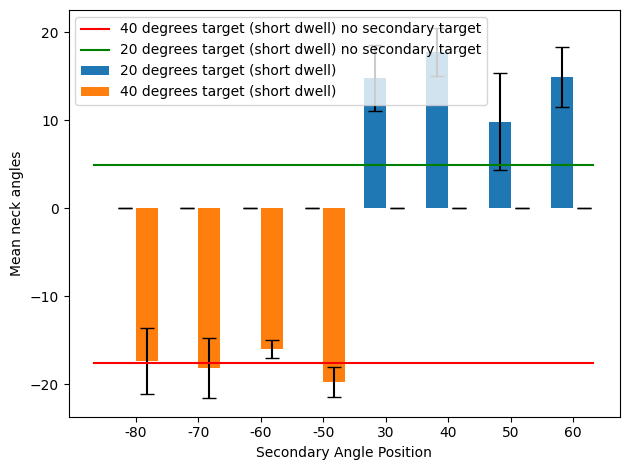

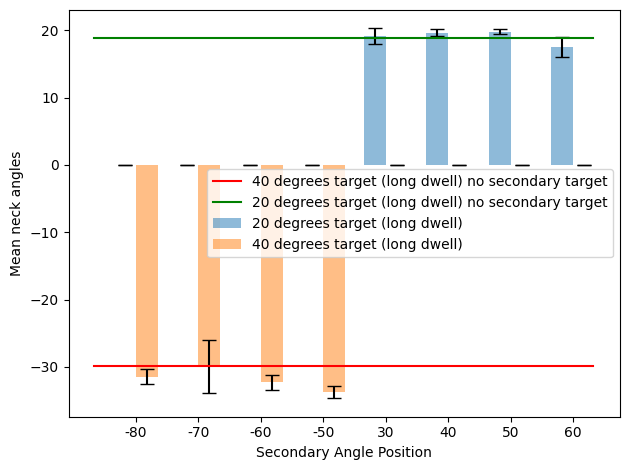

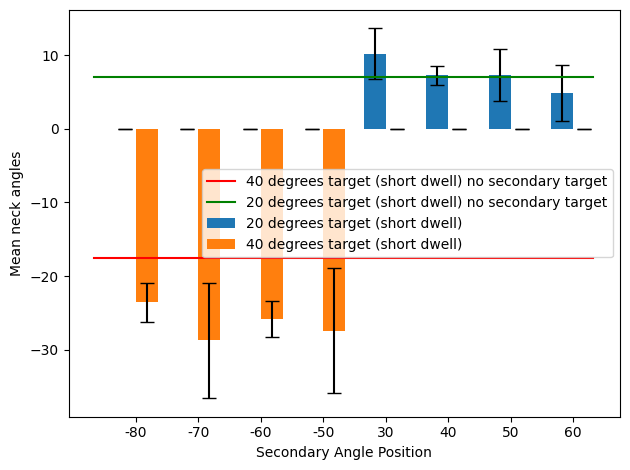

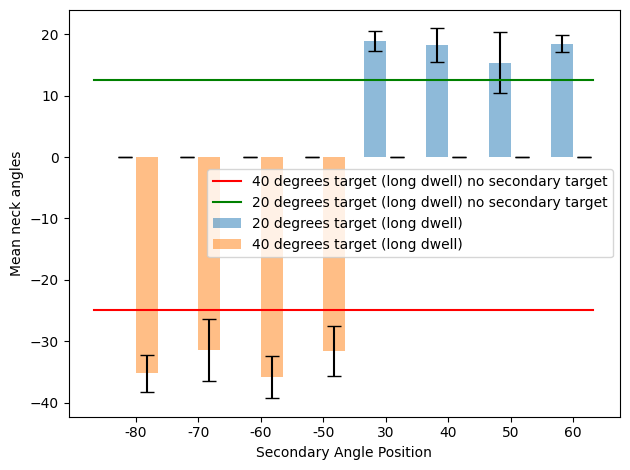

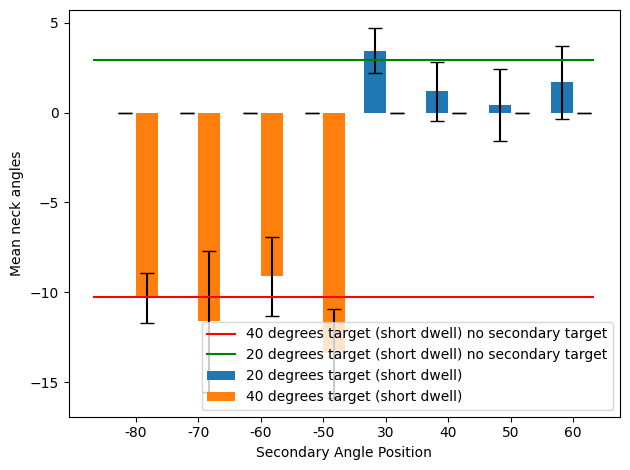

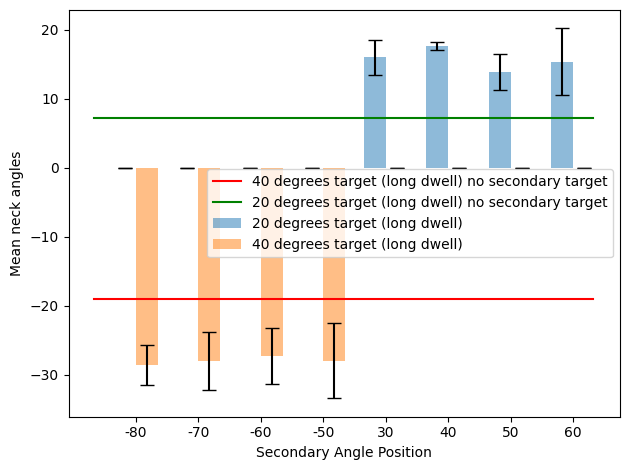

In [58]:
all_start_end_tuples = []
for cp in range(0, len(input_dirs)):
    start_end_tuples = []
    
    # the data with the conditions
    head_dir = all_head_data[cp]
    eye_dir = all_eye_data[cp]
    target_pos = all_target_data[cp]
    target_input = all_target_input[cp]
    target_fixation_angles, target_fixation_duration, fixation_angles, head_fixation_angles, target_present_duration = get_angle_per_instance(head_dir, eye_dir, target_pos, target_input, True)
    # with conditions:
    controlled_head_dir = controlled_trial_head_data[cp]
    controlled_eye_dir = controlled_trial_eye_data[cp]
    controlled_target_pos = controlled_trial_target_data[cp]
    controlled_target_input = controlled_trial_target_input[cp]
    controlled_target_fixation_angles, controlled_target_fixation_duration, controlled_fixation_angles, controlled_head_fixation_angles, controlled_target_present_duration = get_angle_per_instance(controlled_head_dir, controlled_eye_dir, controlled_target_pos, controlled_target_input)

    # cluster the results into dictionaries by dwell time
    result_dict_angle_20_shortdwell = {}
    result_dict_angle_40_shortdwell = {}
    result_dict_angle_20_longdwell = {}
    result_dict_angle_40_longdwell = {}
    
    for i in range(0, int(fixation_angles.shape[0] / 3)):
        if np.abs(fixation_angles[3*i+1] - 20) <= 1E-3:
            if target_present_duration[3*i+1] < 0.2:
                try:
                    result_dict_angle_20_shortdwell[int(np.round(target_fixation_angles[3*i+2]))].append(head_fixation_angles[3*i+1])
                except:
                    result_dict_angle_20_shortdwell[int(np.round(target_fixation_angles[3*i+2]))] = [head_fixation_angles[3*i+1]]
            else:
                try:
                    result_dict_angle_20_longdwell[int(np.round(target_fixation_angles[3*i+2]))].append(head_fixation_angles[3*i+1])
                except:
                    result_dict_angle_20_longdwell[int(np.round(target_fixation_angles[3*i+2]))] = [head_fixation_angles[3*i+1]]                    
        elif np.abs(fixation_angles[3*i+1] + 40) <= 1E-3:
            if target_present_duration[3*i+1] < 0.2:
                try:
                    result_dict_angle_40_shortdwell[int(np.round(target_fixation_angles[3*i+2]))].append(head_fixation_angles[3*i+1])
                except:
                    result_dict_angle_40_shortdwell[int(np.round(target_fixation_angles[3*i+2]))] = [head_fixation_angles[3*i+1]]
            else:
                try:
                    result_dict_angle_40_longdwell[int(np.round(target_fixation_angles[3*i+2]))].append(head_fixation_angles[3*i+1])
                except:
                    result_dict_angle_40_longdwell[int(np.round(target_fixation_angles[3*i+2]))] = [head_fixation_angles[3*i+1]]
    # cluster the results of the controlled group to get the mean gaze angle of those tasks
    result_dict_angle_20_shortdwell_controlled = {}
    result_dict_angle_40_shortdwell_controlled = {}
    result_dict_angle_20_longdwell_controlled = {}
    result_dict_angle_40_longdwell_controlled = {}
    for i in range(0, len(controlled_fixation_angles)):
        if np.abs(controlled_fixation_angles[i] - 20) <= 1E-3:
            if controlled_target_present_duration[i] < 0.2:
                try:
                    result_dict_angle_20_shortdwell_controlled[int(controlled_fixation_angles[i+1])].append(controlled_head_fixation_angles[i])
                except:
                    result_dict_angle_20_shortdwell_controlled[int(controlled_fixation_angles[i+1])] = [controlled_head_fixation_angles[i]]
            else:
                try:
                    result_dict_angle_20_longdwell_controlled[int(controlled_fixation_angles[i+1])].append(controlled_head_fixation_angles[i])
                except:
                    result_dict_angle_20_longdwell_controlled[int(controlled_fixation_angles[i+1])] = [controlled_head_fixation_angles[i]]                    
        elif np.abs(controlled_fixation_angles[i] + 40) <= 1E-3:
            if controlled_target_present_duration[i] < 0.2:
                try:
                    result_dict_angle_40_shortdwell_controlled[int(controlled_fixation_angles[i+1])].append(controlled_head_fixation_angles[i])
                except:
                    result_dict_angle_40_shortdwell_controlled[int(controlled_fixation_angles[i+1])] = [controlled_head_fixation_angles[i]]
            else:
                try:
                    result_dict_angle_40_longdwell_controlled[int(controlled_fixation_angles[i+1])].append(controlled_head_fixation_angles[i])
                except:
                    result_dict_angle_40_longdwell_controlled[int(controlled_fixation_angles[i+1])] = [controlled_head_fixation_angles[i]]

    mean_longdwell_angle40_controlled = np.mean(result_dict_angle_40_longdwell_controlled[0])
    mean_longdwell_angle20_controlled = np.mean(result_dict_angle_20_longdwell_controlled[0])
    mean_shortdwell_angle40_controlled = np.mean(result_dict_angle_40_shortdwell_controlled[0])
    mean_shortdwell_angle20_controlled = np.mean(result_dict_angle_20_shortdwell_controlled[0])
    # Get the unique durations from both dictionaries

    onward_conditions = sorted(set(result_dict_angle_20_shortdwell.keys()) | set(result_dict_angle_40_shortdwell.keys()))

    # Calculate means for each duration from both dictionaries
    means_dict1 = [np.mean(result_dict_angle_20_shortdwell[duration]) if duration in result_dict_angle_20_shortdwell else 0 for duration in onward_conditions]
    means_dict2 = [np.mean(result_dict_angle_40_shortdwell[duration]) if duration in result_dict_angle_40_shortdwell else 0 for duration in onward_conditions]
    stds_dict1 = [np.std(result_dict_angle_20_shortdwell[duration]) if duration in result_dict_angle_20_shortdwell else 0 for duration in onward_conditions]
    stds_dict2 = [np.std(result_dict_angle_40_shortdwell[duration]) if duration in result_dict_angle_40_shortdwell else 0 for duration in onward_conditions]
    
    means_dict3 = [np.mean(result_dict_angle_20_longdwell[duration]) if duration in result_dict_angle_20_longdwell else 0 for duration in onward_conditions]
    means_dict4 = [np.mean(result_dict_angle_40_longdwell[duration]) if duration in result_dict_angle_40_longdwell else 0 for duration in onward_conditions]
    stds_dict3 = [np.std(result_dict_angle_20_longdwell[duration]) if duration in result_dict_angle_20_longdwell else 0 for duration in onward_conditions]
    stds_dict4 = [np.std(result_dict_angle_40_longdwell[duration]) if duration in result_dict_angle_40_longdwell else 0 for duration in onward_conditions]

    # Define the width of the bars
    bar_width = 0.35

    # Calculate the x-positions for the bars
    x_dict1 = np.arange(len(onward_conditions))
    x_dict2 = x_dict1 + bar_width
    plot_in_order = True
    # Plot the bar graphs
    if plot_in_order:
        # plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

        # Plot bars for data_dict1
        bars_dict1 = plt.bar(x_dict1, means_dict1, width=bar_width, label="20 degrees target (short dwell)", yerr=stds_dict1, capsize=5)
        # Plot bars for data_dict2
        bars_dict2 = plt.bar(x_dict2, means_dict2, width=bar_width, label="40 degrees target (short dwell)", yerr=stds_dict2, capsize=5)
        # draw a horizontal line at mean_longdwell_angle40_controlled
        plt.plot([-0.5, 7.5], [mean_shortdwell_angle40_controlled, mean_shortdwell_angle40_controlled], label="40 degrees target (short dwell) no secondary target", color="red")
        # draw a horizontal line at mean_longdwell_angle20_controlled
        plt.plot([-0.5, 7.5], [mean_shortdwell_angle20_controlled, mean_shortdwell_angle20_controlled], label="20 degrees target (short dwell) no secondary target", color="green")

        plt.xticks(x_dict1 + bar_width / 2, onward_conditions)  # Set x-tick positions and labels
        plt.xlabel('Secondary Angle Position')
        plt.ylabel('Mean neck angles')
        plt.legend()
        plt.tight_layout()  # Ensure the labels fit within the figure
        plt.show()
        bars_dict3 = plt.bar(x_dict1, means_dict3, width=bar_width, label="20 degrees target (long dwell)", yerr=stds_dict3, capsize=5, alpha = 0.5)
        bars_dict4 = plt.bar(x_dict2, means_dict4, width=bar_width, label="40 degrees target (long dwell)", yerr=stds_dict4, capsize=5, alpha = 0.5)
        # draw a horizontal line at mean_longdwell_angle40_controlled
        plt.plot([-0.5, 7.5], [mean_longdwell_angle40_controlled, mean_longdwell_angle40_controlled], label="40 degrees target (long dwell) no secondary target", color="red")
        # draw a horizontal line at mean_longdwell_angle20_controlled
        plt.plot([-0.5, 7.5], [mean_longdwell_angle20_controlled, mean_longdwell_angle20_controlled], label="20 degrees target (long dwell) no secondary target", color="green")

        plt.xticks(x_dict1 + bar_width / 2, onward_conditions)  # Set x-tick positions and labels
        plt.xlabel('Secondary Angle Position')
        plt.ylabel('Mean neck angles')
        plt.legend()
        plt.tight_layout()  # Ensure the labels fit within the figure
        plt.show()

## Examine the Curve for onward conditions

/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_16685/3878065354.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  rot_y = np.sign(vec[0]) * (90 - np.arctan(abs(vec[2])/abs(vec[0])) * 180 / np.pi)
/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_16685/3832364038.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  rot_y = np.sign(vec[0]) * (90 - np.arctan(abs(vec[2])/abs(vec[0])) * 180 / np.pi)


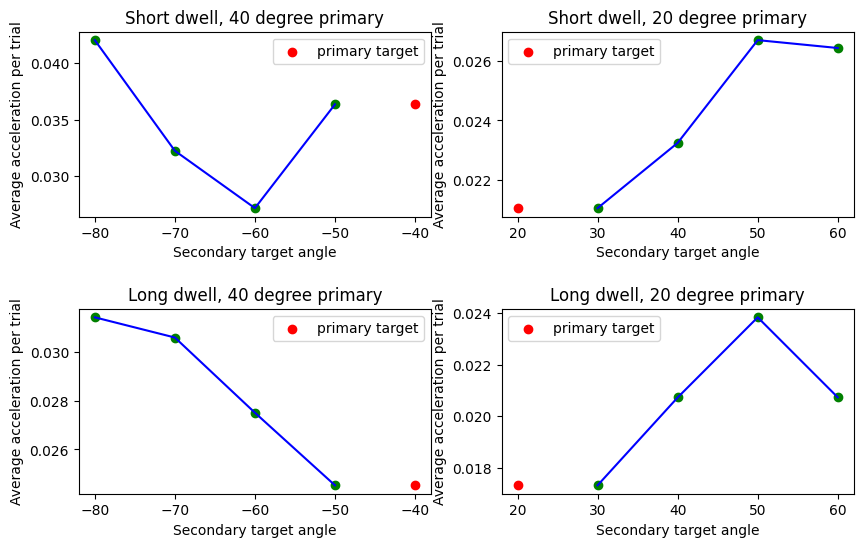

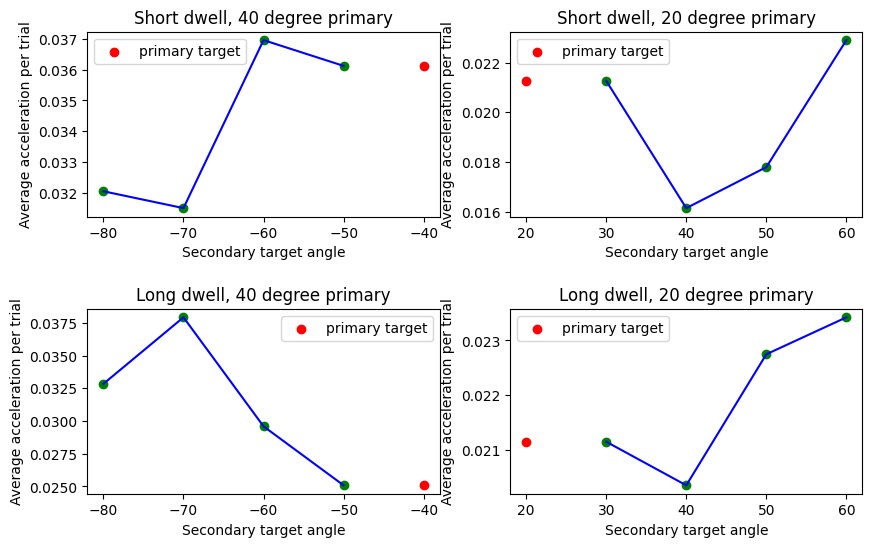

In [22]:
for cp in range(0, len(input_dirs)):
    start_end_tuples = []
    # the data with the conditions
    head_dir = all_head_data[cp]
    eye_dir = all_eye_data[cp]
    target_pos = all_target_data[cp]
    target_dir = np.zeros(target_pos.shape)
    target_dir[:, 0] = target_pos[:, 0]
    for i in range(target_pos.shape[0]):
        # get the object rotation from scipy
        vec = target_pos[i, 1:]
        vec = vec / np.linalg.norm(vec)
        rot_y = np.sign(vec[0]) * (90 - np.arctan(abs(vec[2])/abs(vec[0])) * 180 / np.pi)
        # print(rot_y, target_dir[i, 2])
        target_dir[i, 2] = -rot_y


    target_input = all_target_input[cp]
    target_fixation_angles, target_fixation_duration, fixation_angles, head_fixation_angles, target_present_duration = get_angle_per_instance(head_dir, eye_dir, target_pos, target_input, True)
    target_intervals = get_interval_per_instance(head_dir, eye_dir, target_pos, target_input, True)
    dict_20_degree_onward_angle2trial_index_short_dwell = {}
    dict_40_degree_onward_angle2trial_index_short_dwell = {}
    dict_20_degree_onward_angle2trial_index_long_dwell = {}
    dict_40_degree_onward_angle2trial_index_long_dwell = {}
    
    for i in range(0, int(fixation_angles.shape[0] / 3)):
        if target_fixation_angles[3*i+2] == 0:
            continue
        if target_present_duration[3*i+1] < 0.2:
            if np.abs(fixation_angles[3*i+1] - 20) <= 1E-3:
                try:
                    dict_20_degree_onward_angle2trial_index_short_dwell[int(np.round(target_fixation_angles[3*i+2]))].append(i)
                except:
                    dict_20_degree_onward_angle2trial_index_short_dwell[int(np.round(target_fixation_angles[3*i+2]))] = [i]
            else:
                try:
                    dict_40_degree_onward_angle2trial_index_short_dwell[int(np.round(target_fixation_angles[3*i+2]))].append(i)
                except:
                    dict_40_degree_onward_angle2trial_index_short_dwell[int(np.round(target_fixation_angles[3*i+2]))] = [i]
        elif target_present_duration[3*i+1] >= 0.2:
            if np.abs(fixation_angles[3*i+1] - 20) <= 1E-3:
                try:
                    dict_20_degree_onward_angle2trial_index_long_dwell[int(np.round(target_fixation_angles[3*i+2]))].append(i)
                except:
                    dict_20_degree_onward_angle2trial_index_long_dwell[int(np.round(target_fixation_angles[3*i+2]))] = [i]
            else:
                try:
                    dict_40_degree_onward_angle2trial_index_long_dwell[int(np.round(target_fixation_angles[3*i+2]))].append(i)
                except:
                    dict_40_degree_onward_angle2trial_index_long_dwell[int(np.round(target_fixation_angles[3*i+2]))] = [i]
    
    # compare the aboslute curvature value of the curve
    
    dict_40_degree_onward_angle_2_curvature_short_dwell = {}
    dict_20_degree_onward_angle_2_curvature_short_dwell = {}
    dict_40_degree_onward_angle_2_curvature_long_dwell = {}
    dict_20_degree_onward_angle_2_curvature_long_dwell = {}

    vel_threshold = 0.005
    for i in sorted(dict_40_degree_onward_angle2trial_index_short_dwell.keys()): # for each secondary target angle
        indices = dict_40_degree_onward_angle2trial_index_short_dwell[i] # get the indices of the trials
        for index in indices: 
            # the trajectory of that one trial
            head_traj = head_dir[target_intervals[3*index+1][0]:target_intervals[3*index+2][1]][:, 2]
            vel = np.diff(head_traj, axis=0, prepend=head_traj[0])
            # high accelerating indicates sharp turns in the trajectory
            acc = np.abs(np.diff(vel, axis=0, prepend=vel[0]))
            acc = acc[np.where(np.abs(vel) >= vel_threshold, True, False)]
            avg_acc = np.sum(acc)/acc.shape[0]
            try:
                dict_40_degree_onward_angle_2_curvature_short_dwell[i].append(avg_acc)
            except:
                dict_40_degree_onward_angle_2_curvature_short_dwell[i] = [avg_acc]
    for i in sorted(dict_20_degree_onward_angle2trial_index_short_dwell.keys()): # for each secondary target angle
        indices = dict_20_degree_onward_angle2trial_index_short_dwell[i] # get the indices of the trials
        for index in indices:
            # the trajectory of that one trial
            head_traj = head_dir[target_intervals[3*index+1][0]:target_intervals[3*index+2][1]][:, 2]
            vel = np.diff(head_traj, axis=0, prepend=head_traj[0])
            # high accelerating indicates sharp turns in the trajectory
            acc = np.abs(np.diff(vel, axis=0, prepend=vel[0]))
            acc = acc[np.where(np.abs(vel) >= vel_threshold, True, False)]
            # when computing the mean, only consider the values where the velocity is above 0.1
            avg_acc = np.sum(acc)/acc.shape[0]
            try:
                dict_20_degree_onward_angle_2_curvature_short_dwell[i].append(avg_acc)
            except:
                dict_20_degree_onward_angle_2_curvature_short_dwell[i] = [avg_acc]
    for i in sorted(dict_40_degree_onward_angle2trial_index_long_dwell.keys()): # for each secondary target angle
        indices = dict_40_degree_onward_angle2trial_index_long_dwell[i] # get the indices of the trials
        for index in indices:
            # the trajectory of that one trial
            head_traj = head_dir[target_intervals[3*index+1][0]:target_intervals[3*index+2][1]][:, 2]
            vel = np.diff(head_traj, axis=0, prepend=head_traj[0])
            # high accelerating indicates sharp turns in the trajectory
            acc = np.abs(np.diff(vel, axis=0, prepend=vel[0]))
            acc = acc[np.where(np.abs(vel) >= vel_threshold, True, False)]
            avg_acc = np.sum(acc)/acc.shape[0]
            try:
                dict_40_degree_onward_angle_2_curvature_long_dwell[i].append(avg_acc)
            except:
                dict_40_degree_onward_angle_2_curvature_long_dwell[i] = [avg_acc]
    for i in sorted(dict_20_degree_onward_angle2trial_index_long_dwell.keys()): # for each secondary target angle
        indices = dict_20_degree_onward_angle2trial_index_long_dwell[i] # get the indices of the trials
        for index in indices:
            # the trajectory of that one trial
            head_traj = head_dir[target_intervals[3*index+1][0]:target_intervals[3*index+2][1]][:, 2]
            vel = np.diff(head_traj, axis=0, prepend=head_traj[0])
            # high accelerating indicates sharp turns in the trajectory
            acc = np.abs(np.diff(vel, axis=0, prepend=vel[0]))
            acc = acc[np.where(np.abs(vel) >= vel_threshold, True, False)]
            avg_acc = np.sum(acc)/acc.shape[0]
            try:
                dict_20_degree_onward_angle_2_curvature_long_dwell[i].append(avg_acc)
            except:
                dict_20_degree_onward_angle_2_curvature_long_dwell[i] = [avg_acc]
    # plot the average curvature for each angle as a series of blox plots
    plot_curvature_box_plot = False
    if plot_curvature_box_plot:
        plt.figure(figsize=(10, 6))
        # increase the distance between subplots
        plt.subplots_adjust(hspace=0.5)
        plt.subplot(2, 2, 1)
        plt.title("Short dwell, 40 degree primary")
        for i in sorted(dict_40_degree_onward_angle_2_curvature_short_dwell.keys()):
            plt.boxplot(dict_40_degree_onward_angle_2_curvature_short_dwell[i], positions=[i], widths=0.5)
        plt.xlabel("Secondary target angle")
        plt.ylabel("Average acceleration of trajectory")
        plt.subplot(2, 2, 2)
        plt.title("Short dwell, 20 degree primary")
        for i in sorted(dict_20_degree_onward_angle_2_curvature_short_dwell.keys()):
            plt.boxplot(dict_20_degree_onward_angle_2_curvature_short_dwell[i], positions=[i], widths=0.5)
        plt.xlabel("Secondary target angle")
        plt.ylabel("Average acceleration of trajectory")
        plt.subplot(2, 2, 3)
        plt.title("Long dwell, 40 degree primary")
        for i in sorted(dict_40_degree_onward_angle_2_curvature_long_dwell.keys()):
            plt.boxplot(dict_40_degree_onward_angle_2_curvature_long_dwell[i], positions=[i], widths=0.5)
        plt.xlabel("Secondary target angle")
        plt.ylabel("Average acceleration of trajectory")
        plt.subplot(2, 2, 4)
        plt.title("Long dwell, 20 degree primary")
        for i in sorted(dict_20_degree_onward_angle_2_curvature_long_dwell.keys()):
            plt.boxplot(dict_20_degree_onward_angle_2_curvature_long_dwell[i], positions=[i], widths=0.5)
        plt.xlabel("Secondary target angle")
        plt.ylabel("Average acceleration of trajectory")
        plt.show()

    # plot the average of average curvature for each angle as a series scatter plots
    plot_curvature_scatter_plot = True
    if plot_curvature_scatter_plot:
        # size of the plot
        plt.figure(figsize=(10, 6))
        # increase the distance between subplots
        plt.subplots_adjust(hspace=0.5)
        plt.subplot(2, 2, 1)
        plt.title("Short dwell, 40 degree primary")
        x_arr = []
        y_arr = []
        for i in sorted(dict_40_degree_onward_angle_2_curvature_short_dwell.keys()):
            plt.scatter([i], [np.mean(dict_40_degree_onward_angle_2_curvature_short_dwell[i])], color="green")
            x_arr.append(i)
            y_arr.append(np.mean(dict_40_degree_onward_angle_2_curvature_short_dwell[i]))
        # show the point of the primary target
        plt.scatter([-40], [y_arr[-1]], color="red", label="primary target")
        # add a line that go through all the points
        plt.plot(x_arr, y_arr, color="blue")
        plt.xlabel("Secondary target angle")
        plt.ylabel("Average acceleration per trial")
        plt.legend()
        plt.subplot(2, 2, 2)
        plt.title("Short dwell, 20 degree primary")
        x_arr = []
        y_arr = []
        for i in sorted(dict_20_degree_onward_angle_2_curvature_short_dwell.keys()):
            plt.scatter([i], [np.mean(dict_20_degree_onward_angle_2_curvature_short_dwell[i])], color="green")
            x_arr.append(i)
            y_arr.append(np.mean(dict_20_degree_onward_angle_2_curvature_short_dwell[i]))
        plt.scatter([20], [y_arr[0]], color="red", label="primary target")
        # add a line that go through all the points
        plt.plot(x_arr, y_arr, color="blue")
        plt.xlabel("Secondary target angle")
        plt.ylabel("Average acceleration per trial")
        plt.legend()
        plt.subplot(2, 2, 3)
        x_arr = []
        y_arr = []
        plt.title("Long dwell, 40 degree primary")
        for i in sorted(dict_40_degree_onward_angle_2_curvature_long_dwell.keys()):
            plt.scatter([i], [np.mean(dict_40_degree_onward_angle_2_curvature_long_dwell[i])], color="green")
            x_arr.append(i)
            y_arr.append(np.mean(dict_40_degree_onward_angle_2_curvature_long_dwell[i]))
        plt.scatter([-40], [y_arr[-1]], color="red", label="primary target")
        # add a line that go through all the points
        plt.plot(x_arr, y_arr, color="blue")
        plt.xlabel("Secondary target angle")
        plt.ylabel("Average acceleration per trial")
        plt.legend()
        plt.subplot(2, 2, 4)
        x_arr = []
        y_arr = []
        plt.title("Long dwell, 20 degree primary")
        for i in sorted(dict_20_degree_onward_angle_2_curvature_long_dwell.keys()):
            plt.scatter([i], [np.mean(dict_20_degree_onward_angle_2_curvature_long_dwell[i])], color="green")
            x_arr.append(i)
            y_arr.append(np.mean(dict_20_degree_onward_angle_2_curvature_long_dwell[i]))
        plt.scatter([20], [y_arr[0]], color="red", label="primary target")
        # add a line that go through all the points
        plt.plot(x_arr, y_arr, color="blue")
        plt.xlabel("Secondary target angle")
        plt.ylabel("Average acceleration per trial")
        plt.legend()
        plt.show()

    plotting_trajectory = False
    long_dwell = True
    # plot the head trajectories for each trial with a long duration
    if long_dwell and plotting_trajectory:
        for i in sorted(dict_40_degree_onward_angle2trial_index_long_dwell.keys()):
            indices = dict_40_degree_onward_angle2trial_index_long_dwell[i]
            for index in indices:
                time_arr = head_dir[target_intervals[3*index+1][0]:target_intervals[3*index+2][1]][:, 0]
                time_arr = (time_arr - time_arr[0]) * 1000
                plt.plot(time_arr, head_dir[target_intervals[3*index+1][0]:target_intervals[3*index+2][1]][:, 2:3], label="head")
                # plt.plot(time_arr, eye_dir[target_intervals[3*i+1][0]:target_intervals[3*i+2][1]][:, 2:3] + head_dir[target_intervals[3*i+1][0]:target_intervals[3*i+2][1]][:, 2:3], label="eye")
                # plt.plot(time_arr, target_dir[target_intervals[3*index+1][0]:target_intervals[3*index+2][1]][:, 2:3], label="target")
                # show the moment the eye fixates on the target as a dot
                plt.xlabel("time (ms)")
                plt.title("Primary target at 40 degrees (long dwell), secondary target at " + str(i) + " degrees")
            plt.show()
        for i in sorted(dict_20_degree_onward_angle2trial_index_long_dwell.keys()):
            indices = dict_20_degree_onward_angle2trial_index_long_dwell[i]
            for index in indices:
                time_arr = head_dir[target_intervals[3*index+1][0]:target_intervals[3*index+2][1]][:, 0]
                time_arr = (time_arr - time_arr[0]) * 1000
                plt.plot(time_arr, head_dir[target_intervals[3*index+1][0]:target_intervals[3*index+2][1]][:, 2:3], label="head")
                # plt.plot(time_arr, eye_dir[target_intervals[3*i+1][0]:target_intervals[3*i+2][1]][:, 2:3] + head_dir[target_intervals[3*i+1][0]:target_intervals[3*i+2][1]][:, 2:3], label="eye")
                # plt.plot(time_arr, target_dir[target_intervals[3*index+1][0]:target_intervals[3*index+2][1]][:, 2:3], label="target")
                # show the moment the eye fixates on the target as a dot
                plt.xlabel("time (ms)")
                plt.title("Primary target at 20 degrees (long dwell), secondary target at " + str(i) + " degrees")
            plt.show()
    elif plotting_trajectory and not long_dwell:
        for i in sorted(dict_40_degree_onward_angle2trial_index_long_dwell.keys()):
            indices = dict_40_degree_onward_angle2trial_index_long_dwell[i]
            for index in indices:
                time_arr = head_dir[target_intervals[3*index+1][0]:target_intervals[3*index+2][1]][:, 0]
                time_arr = (time_arr - time_arr[0]) * 1000
                plt.plot(time_arr, head_dir[target_intervals[3*index+1][0]:target_intervals[3*index+2][1]][:, 2:3], label="head")
                # plt.plot(time_arr, eye_dir[target_intervals[3*i+1][0]:target_intervals[3*i+2][1]][:, 2:3] + head_dir[target_intervals[3*i+1][0]:target_intervals[3*i+2][1]][:, 2:3], label="eye")
                # plt.plot(time_arr, target_dir[target_intervals[3*index+1][0]:target_intervals[3*index+2][1]][:, 2:3], label="target")
                # show the moment the eye fixates on the target as a dot
                plt.xlabel("time (ms)")
                plt.title("Primary target at 40 degrees (long dwell), secondary target at " + str(i) + " degrees")
            plt.show()
        for i in sorted(dict_20_degree_onward_angle2trial_index_long_dwell.keys()):
            indices = dict_20_degree_onward_angle2trial_index_long_dwell[i]
            for index in indices:
                time_arr = head_dir[target_intervals[3*index+1][0]:target_intervals[3*index+2][1]][:, 0]
                time_arr = (time_arr - time_arr[0]) * 1000
                plt.plot(time_arr, head_dir[target_intervals[3*index+1][0]:target_intervals[3*index+2][1]][:, 2:3], label="head")
                # plt.plot(time_arr, eye_dir[target_intervals[3*i+1][0]:target_intervals[3*i+2][1]][:, 2:3] + head_dir[target_intervals[3*i+1][0]:target_intervals[3*i+2][1]][:, 2:3], label="eye")
                # plt.plot(time_arr, target_dir[target_intervals[3*index+1][0]:target_intervals[3*index+2][1]][:, 2:3], label="target")
                # show the moment the eye fixates on the target as a dot
                plt.xlabel("time (ms)")
                plt.title("Primary target at 20 degrees (long dwell), secondary target at " + str(i) + " degrees")
            plt.show()
    print("===========================================")
            


# Analyze the data for the rapid direction change experiment

## compare distribution

/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_43895/1387733458.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  rot_y = np.sign(vec[0]) * (90 - np.arctan(abs(vec[2])/abs(vec[0])) * 180 / np.pi)


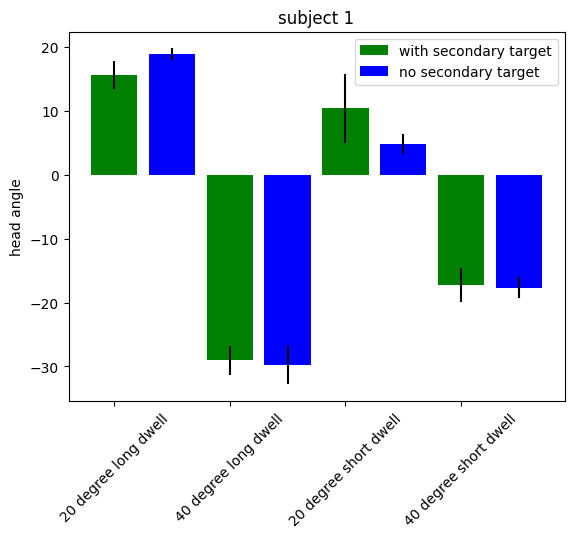

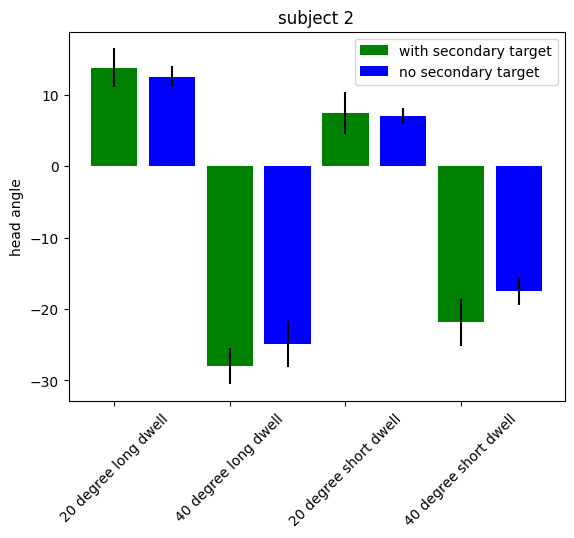

In [304]:
for cp in range(0, len(input_dirs)):
    head_dir = all_head_data_rapid_dir_change[cp]
    eye_dir = all_eye_data_rapid_dir_change[cp]
    target_pos = all_target_data_rapid_dir_change[cp]
    target_input = all_target_input_rapid_dir_change[cp]
    target_fixation_angles, target_fixation_duration, fixation_angles, head_fixation_angles, target_present_duration = get_angle_per_instance(head_dir, eye_dir, target_pos, target_input, True)
    # with conditions:
    controlled_head_dir = controlled_trial_head_data[cp]
    controlled_eye_dir = controlled_trial_eye_data[cp]
    controlled_target_pos = controlled_trial_target_data[cp]
    controlled_target_input = controlled_trial_target_input[cp]
    controlled_target_fixation_angles, controlled_target_fixation_duration, controlled_fixation_angles, controlled_head_fixation_angles, controlled_target_present_duration = get_angle_per_instance(controlled_head_dir, controlled_eye_dir, controlled_target_pos, controlled_target_input)

    # get indices of target fixation where the primary angle is 20 degrees
    indices_20_degrees_longdwell = []
    indices_40_degrees_longdwell = []
    indices_20_degrees_shortdwell = []
    indices_40_degrees_shortdwell = []

    offset = 0
    for i in range(0, int(target_fixation_angles.shape[0])):
        if i+offset >= fixation_angles.shape[0]:
            break
        if np.abs(fixation_angles[i+offset] - target_fixation_angles[i]) < 1:
            pass
        else: 
            offset -= 1
            continue
        if i+offset >= fixation_angles.shape[0]:
            break
        if np.abs(fixation_angles[i+offset] - 20) <= 1:
            if target_present_duration[i] < 0.2:
                indices_20_degrees_shortdwell.append(i+offset)
            else:
                indices_20_degrees_longdwell.append(i+offset)
        elif np.abs(fixation_angles[i+offset] + 40) <= 1:
            if target_present_duration[i] < 0.2:
                indices_40_degrees_shortdwell.append(i+offset)
            else:
                indices_40_degrees_longdwell.append(i+offset)
    indices_20_degrees_controlled_longdwell = []
    indices_40_degrees_controlled_longdwell = []
    indices_20_degrees_controlled_shortdwell = []
    indices_40_degrees_controlled_shortdwell = []
    # print(target_fixation_angles)
    for i in range(0, len(controlled_target_fixation_angles)):
        if int(np.round(controlled_target_fixation_angles[i])) == 20:
            if controlled_target_present_duration[i] >= 0.3:
                indices_20_degrees_controlled_longdwell.append(i)
            else:
                indices_20_degrees_controlled_shortdwell.append(i)
        elif int(np.round(controlled_target_fixation_angles[i])) == -40:
            if controlled_target_present_duration[i] >= 0.3:
                indices_40_degrees_controlled_longdwell.append(i)
            else:
                indices_40_degrees_controlled_shortdwell.append(i)
    mean_20_degree_longdwell = np.mean(head_fixation_angles[indices_20_degrees_longdwell])
    mean_40_degree_longdwell = np.mean(head_fixation_angles[indices_40_degrees_longdwell])
    mean_20_degree_shortdwell = np.mean(head_fixation_angles[indices_20_degrees_shortdwell])
    mean_40_degree_shortdwell = np.mean(head_fixation_angles[indices_40_degrees_shortdwell])
    mean_20_degree_controlled_longdwell = np.mean(controlled_head_fixation_angles[indices_20_degrees_controlled_longdwell])
    mean_40_degree_controlled_longdwell = np.mean(controlled_head_fixation_angles[indices_40_degrees_controlled_longdwell])
    mean_20_degree_controlled_shortdwell = np.mean(controlled_head_fixation_angles[indices_20_degrees_controlled_shortdwell])
    mean_40_degree_controlled_shortdwell = np.mean(controlled_head_fixation_angles[indices_40_degrees_controlled_shortdwell])
    std_20_degree_longdwell = np.std(head_fixation_angles[indices_20_degrees_longdwell])
    std_40_degree_longdwell = np.std(head_fixation_angles[indices_40_degrees_longdwell])
    std_20_degree_shortdwell = np.std(head_fixation_angles[indices_20_degrees_shortdwell])
    std_40_degree_shortdwell = np.std(head_fixation_angles[indices_40_degrees_shortdwell])
    std_20_degree_controlled_longdwell = np.std(controlled_head_fixation_angles[indices_20_degrees_controlled_longdwell])
    std_40_degree_controlled_longdwell = np.std(controlled_head_fixation_angles[indices_40_degrees_controlled_longdwell])
    std_20_degree_controlled_shortdwell = np.std(controlled_head_fixation_angles[indices_20_degrees_controlled_shortdwell])
    std_40_degree_controlled_shortdwell = np.std(controlled_head_fixation_angles[indices_40_degrees_controlled_shortdwell])


    # plot the pairwise comparison as a series of bar graph with 4 pairs of controlled vs not controlled conditions, plot std as error bar, all on the same graph
    plt.figure()
    plt.title("subject " + str(cp+1))
    # label the controlled condition and not controlled condition
    plt.bar([0, 1], [mean_20_degree_longdwell, mean_20_degree_controlled_longdwell], yerr=[std_20_degree_longdwell, std_20_degree_controlled_longdwell], label=["with secondary target", "no secondary target"], color=["green", "blue"])
    plt.bar([2, 3], [mean_40_degree_longdwell, mean_40_degree_controlled_longdwell], yerr=[std_40_degree_longdwell, std_40_degree_controlled_longdwell], color=["green", "blue"])
    plt.bar([4, 5], [mean_20_degree_shortdwell, mean_20_degree_controlled_shortdwell], yerr=[std_20_degree_shortdwell, std_20_degree_controlled_shortdwell], color=["green", "blue"])
    plt.bar([6, 7], [mean_40_degree_shortdwell, mean_40_degree_controlled_shortdwell], yerr=[std_40_degree_shortdwell, std_40_degree_controlled_shortdwell], color=["green", "blue"])
    # label the angle and dwell time for each pair
    plt.xticks([0, 2, 4, 6], ["20 degree long dwell", "40 degree long dwell", "20 degree short dwell", "40 degree short dwell", ])
    plt.ylabel("head angle")
    # make the x ticks slanted
    plt.xticks(rotation=45)
    
    
    plt.legend()
    plt.show()

    
 


## plot out the head/eye coordination data:

/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_43895/1387733458.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  rot_y = np.sign(vec[0]) * (90 - np.arctan(abs(vec[2])/abs(vec[0])) * 180 / np.pi)


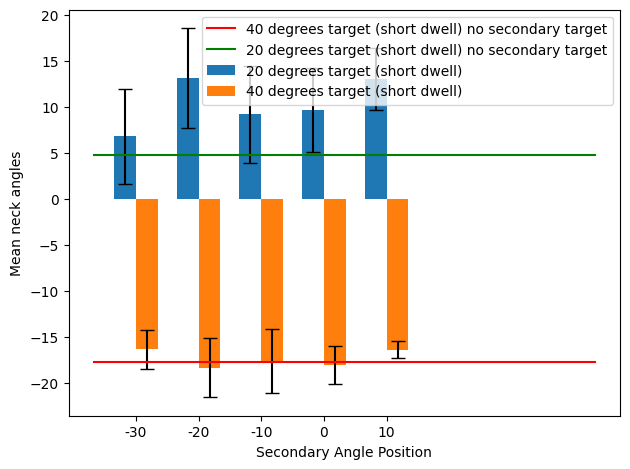

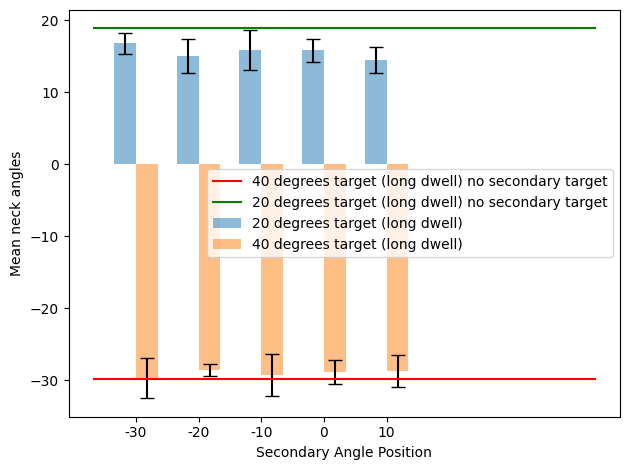

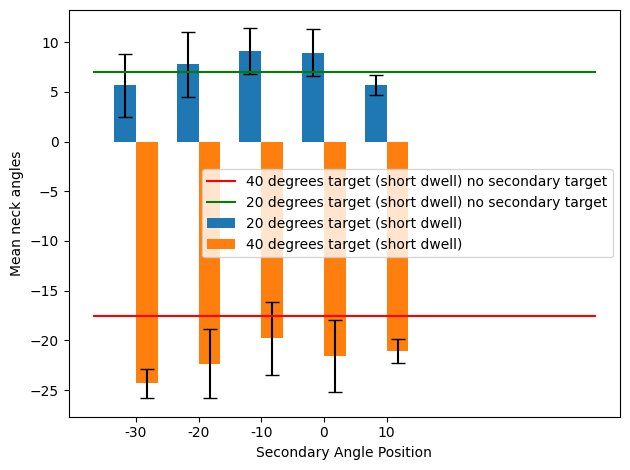

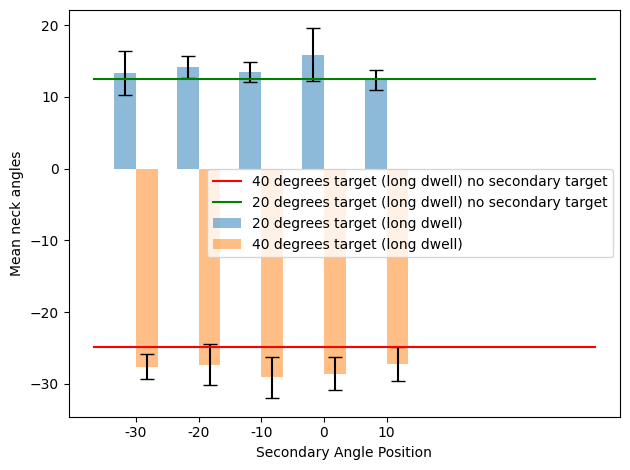

In [302]:
all_start_end_tuples = []
for cp in range(0, len(input_dirs)):
    start_end_tuples = []
    
    # the data with the conditions
    head_dir = all_head_data_rapid_dir_change[cp]
    eye_dir = all_eye_data_rapid_dir_change[cp]
    target_pos = all_target_data_rapid_dir_change[cp]
    target_input = all_target_input_rapid_dir_change[cp]
    target_fixation_angles, target_fixation_duration, fixation_angles, head_fixation_angles, target_present_duration = get_angle_per_instance(head_dir, eye_dir, target_pos, target_input, False)
    # with conditions:
    controlled_head_dir = controlled_trial_head_data[cp]
    controlled_eye_dir = controlled_trial_eye_data[cp]
    controlled_target_pos = controlled_trial_target_data[cp]
    controlled_target_input = controlled_trial_target_input[cp]
    controlled_target_fixation_angles, controlled_target_fixation_duration, controlled_fixation_angles, controlled_head_fixation_angles, controlled_target_present_duration = get_angle_per_instance(controlled_head_dir, controlled_eye_dir, controlled_target_pos, controlled_target_input)

    # cluster the results into dictionaries by dwell time
    result_dict_angle_20_shortdwell = {}
    result_dict_angle_40_shortdwell = {}
    result_dict_angle_20_longdwell = {}
    result_dict_angle_40_longdwell = {}
    offset = 0
    for i in range(0, int(target_fixation_angles.shape[0])):
        if i+offset >= fixation_angles.shape[0]:
            break
        if np.abs(fixation_angles[i+offset] - target_fixation_angles[i]) < 1:
            pass
        else: 
            offset -= 1
            continue
        if i+offset >= fixation_angles.shape[0]:
            break
        if np.abs(fixation_angles[i+offset] - 20) <= 1:
            if target_present_duration[i] < 0.2:
                try:
                    result_dict_angle_20_shortdwell[int(np.round(target_fixation_angles[i+1]))].append(head_fixation_angles[i+offset])
                except:
                    result_dict_angle_20_shortdwell[int(np.round(target_fixation_angles[i+1]))] = [head_fixation_angles[i+offset]]
            else:
                try:
                    result_dict_angle_20_longdwell[int(np.round(target_fixation_angles[i+1]))].append(head_fixation_angles[i+offset])
                except:
                    result_dict_angle_20_longdwell[int(np.round(target_fixation_angles[i+1]))] = [head_fixation_angles[i+offset]]
        elif np.abs(fixation_angles[i+offset] + 40) <= 1:
            if target_present_duration[i] < 0.2:
                try:
                    result_dict_angle_40_shortdwell[int(np.round(target_fixation_angles[i+1]))].append(head_fixation_angles[i+offset])
                except:
                    result_dict_angle_40_shortdwell[int(np.round(target_fixation_angles[i+1]))] = [head_fixation_angles[i+offset]]
            else:
                try:
                    result_dict_angle_40_longdwell[int(np.round(target_fixation_angles[i+1]))].append(head_fixation_angles[i+offset])
                except:
                    result_dict_angle_40_longdwell[int(np.round(target_fixation_angles[i+1]))] = [head_fixation_angles[i+offset]]

        
            
    # cluster the results of the controlled group to get the mean gaze angle of those tasks
    result_dict_angle_20_shortdwell_controlled = {}
    result_dict_angle_40_shortdwell_controlled = {}
    result_dict_angle_20_longdwell_controlled = {}
    result_dict_angle_40_longdwell_controlled = {}
    for i in range(0, len(controlled_fixation_angles)):
        if np.abs(controlled_fixation_angles[i] - 20) <= 1E-3:
            if controlled_target_present_duration[i] < 0.2:
                try:
                    result_dict_angle_20_shortdwell_controlled[int(controlled_fixation_angles[i+1])].append(controlled_head_fixation_angles[i])
                except:
                    result_dict_angle_20_shortdwell_controlled[int(controlled_fixation_angles[i+1])] = [controlled_head_fixation_angles[i]]
            else:
                try:
                    result_dict_angle_20_longdwell_controlled[int(controlled_fixation_angles[i+1])].append(controlled_head_fixation_angles[i])
                except:
                    result_dict_angle_20_longdwell_controlled[int(controlled_fixation_angles[i+1])] = [controlled_head_fixation_angles[i]]                    
        elif np.abs(controlled_fixation_angles[i] + 40) <= 1E-3:
            if controlled_target_present_duration[i] < 0.2:
                try:
                    result_dict_angle_40_shortdwell_controlled[int(controlled_fixation_angles[i+1])].append(controlled_head_fixation_angles[i])
                except:
                    result_dict_angle_40_shortdwell_controlled[int(controlled_fixation_angles[i+1])] = [controlled_head_fixation_angles[i]]
            else:
                try:
                    result_dict_angle_40_longdwell_controlled[int(controlled_fixation_angles[i+1])].append(controlled_head_fixation_angles[i])
                except:
                    result_dict_angle_40_longdwell_controlled[int(controlled_fixation_angles[i+1])] = [controlled_head_fixation_angles[i]]

    mean_longdwell_angle40_controlled = np.mean(result_dict_angle_40_longdwell_controlled[0])
    mean_longdwell_angle20_controlled = np.mean(result_dict_angle_20_longdwell_controlled[0])
    mean_shortdwell_angle40_controlled = np.mean(result_dict_angle_40_shortdwell_controlled[0])
    mean_shortdwell_angle20_controlled = np.mean(result_dict_angle_20_shortdwell_controlled[0])
    # Get the unique durations from both dictionaries

    onward_conditions = sorted(set(result_dict_angle_20_shortdwell.keys()) | set(result_dict_angle_40_shortdwell.keys()))

    # Calculate means for each duration from both dictionaries
    means_dict1 = [np.mean(result_dict_angle_20_shortdwell[duration]) if duration in result_dict_angle_20_shortdwell else 0 for duration in onward_conditions]
    means_dict2 = [np.mean(result_dict_angle_40_shortdwell[duration]) if duration in result_dict_angle_40_shortdwell else 0 for duration in onward_conditions]
    stds_dict1 = [np.std(result_dict_angle_20_shortdwell[duration]) if duration in result_dict_angle_20_shortdwell else 0 for duration in onward_conditions]
    stds_dict2 = [np.std(result_dict_angle_40_shortdwell[duration]) if duration in result_dict_angle_40_shortdwell else 0 for duration in onward_conditions]
    
    means_dict3 = [np.mean(result_dict_angle_20_longdwell[duration]) if duration in result_dict_angle_20_longdwell else 0 for duration in onward_conditions]
    means_dict4 = [np.mean(result_dict_angle_40_longdwell[duration]) if duration in result_dict_angle_40_longdwell else 0 for duration in onward_conditions]
    stds_dict3 = [np.std(result_dict_angle_20_longdwell[duration]) if duration in result_dict_angle_20_longdwell else 0 for duration in onward_conditions]
    stds_dict4 = [np.std(result_dict_angle_40_longdwell[duration]) if duration in result_dict_angle_40_longdwell else 0 for duration in onward_conditions]

    # Define the width of the bars
    bar_width = 0.35

    # Calculate the x-positions for the bars
    x_dict1 = np.arange(len(onward_conditions))
    x_dict2 = x_dict1 + bar_width
    plot_in_order = True
    # Plot the bar graphs
    if plot_in_order:
        # plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

        # Plot bars for data_dict1
        bars_dict1 = plt.bar(x_dict1, means_dict1, width=bar_width, label="20 degrees target (short dwell)", yerr=stds_dict1, capsize=5)
        # Plot bars for data_dict2
        bars_dict2 = plt.bar(x_dict2, means_dict2, width=bar_width, label="40 degrees target (short dwell)", yerr=stds_dict2, capsize=5)
        # draw a horizontal line at mean_longdwell_angle40_controlled
        plt.plot([-0.5, 7.5], [mean_shortdwell_angle40_controlled, mean_shortdwell_angle40_controlled], label="40 degrees target (short dwell) no secondary target", color="red")
        # draw a horizontal line at mean_longdwell_angle20_controlled
        plt.plot([-0.5, 7.5], [mean_shortdwell_angle20_controlled, mean_shortdwell_angle20_controlled], label="20 degrees target (short dwell) no secondary target", color="green")

        plt.xticks(x_dict1 + bar_width / 2, onward_conditions)  # Set x-tick positions and labels
        plt.xlabel('Secondary Angle Position')
        plt.ylabel('Mean neck angles')
        plt.legend()
        plt.tight_layout()  # Ensure the labels fit within the figure
        plt.show()
        bars_dict3 = plt.bar(x_dict1, means_dict3, width=bar_width, label="20 degrees target (long dwell)", yerr=stds_dict3, capsize=5, alpha = 0.5)
        bars_dict4 = plt.bar(x_dict2, means_dict4, width=bar_width, label="40 degrees target (long dwell)", yerr=stds_dict4, capsize=5, alpha = 0.5)
        # draw a horizontal line at mean_longdwell_angle40_controlled
        plt.plot([-0.5, 7.5], [mean_longdwell_angle40_controlled, mean_longdwell_angle40_controlled], label="40 degrees target (long dwell) no secondary target", color="red")
        # draw a horizontal line at mean_longdwell_angle20_controlled
        plt.plot([-0.5, 7.5], [mean_longdwell_angle20_controlled, mean_longdwell_angle20_controlled], label="20 degrees target (long dwell) no secondary target", color="green")

        plt.xticks(x_dict1 + bar_width / 2, onward_conditions)  # Set x-tick positions and labels
        plt.xlabel('Secondary Angle Position')
        plt.ylabel('Mean neck angles')
        plt.legend()
        plt.tight_layout()  # Ensure the labels fit within the figure
        plt.show()

/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_43895/1113442757.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  rot_y = np.sign(vec[0]) * (90 - np.arctan(abs(vec[2])/abs(vec[0])) * 180 / np.pi)
/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_43895/3927008613.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  rot_y = np.sign(vec[0]) * (90 - np.arctan(abs(vec[2])/abs(vec[0])) * 180 / np.pi)


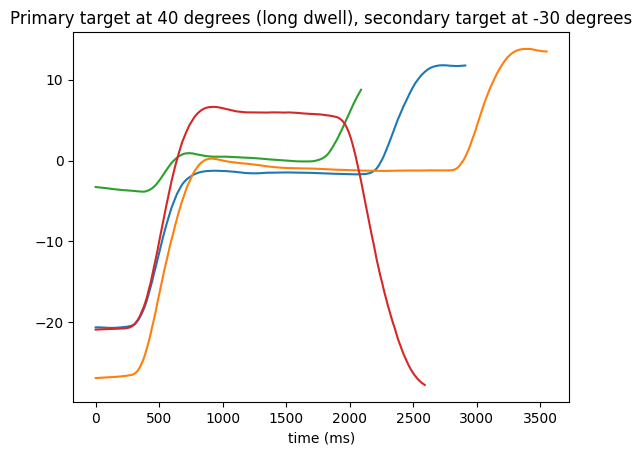

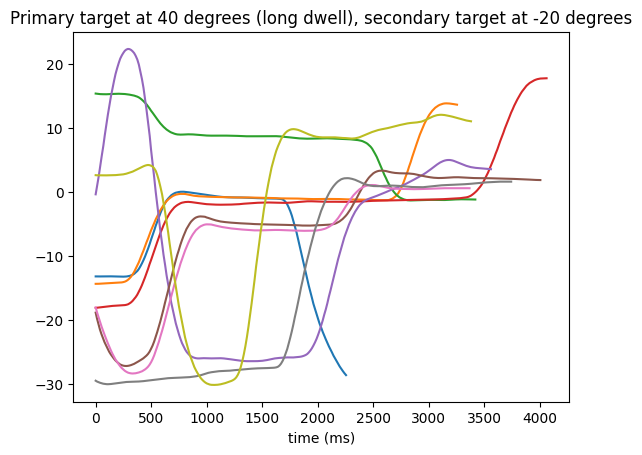

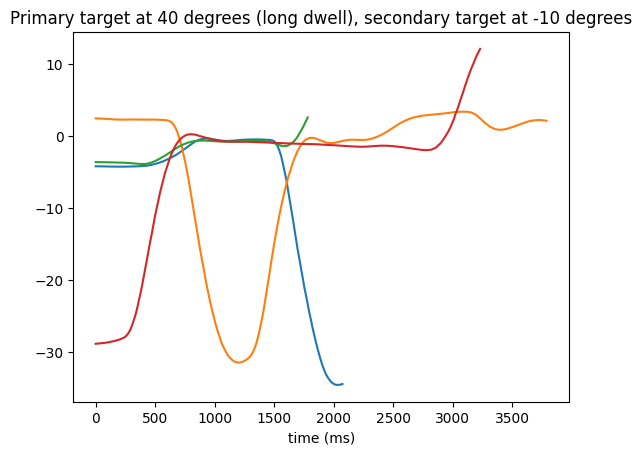

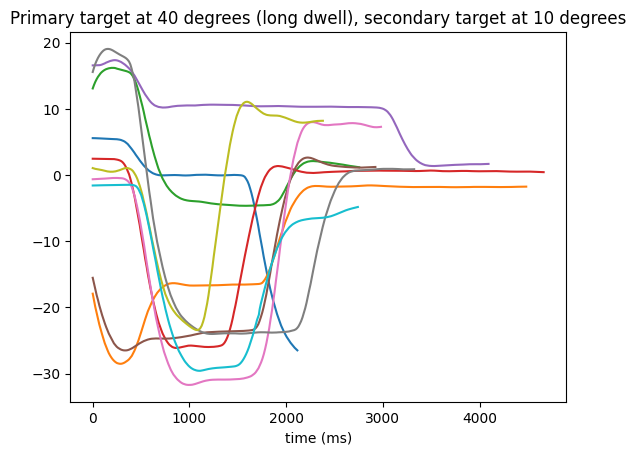

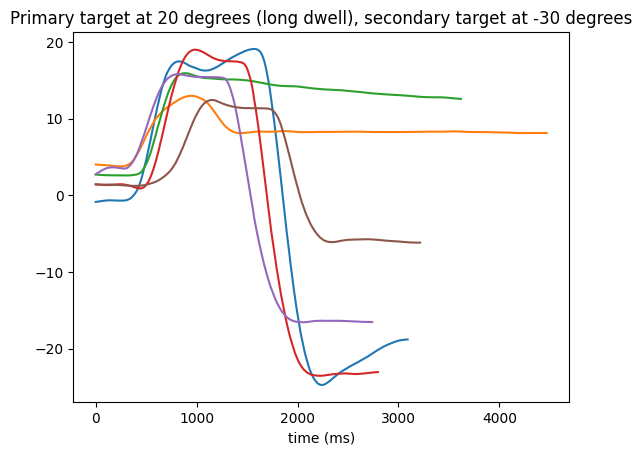

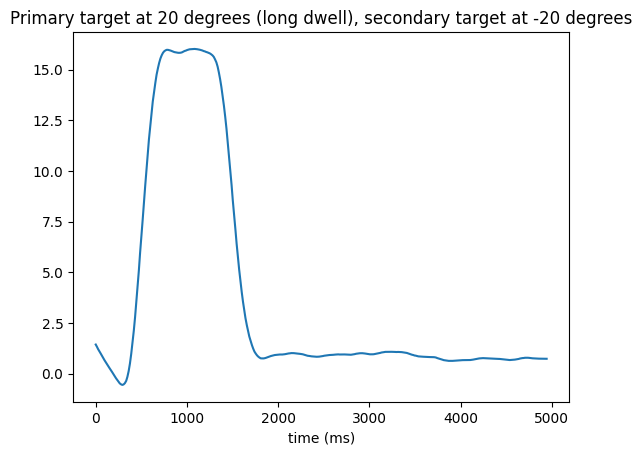

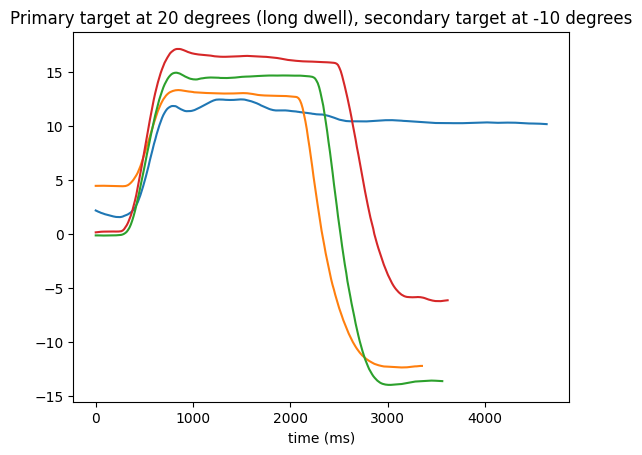

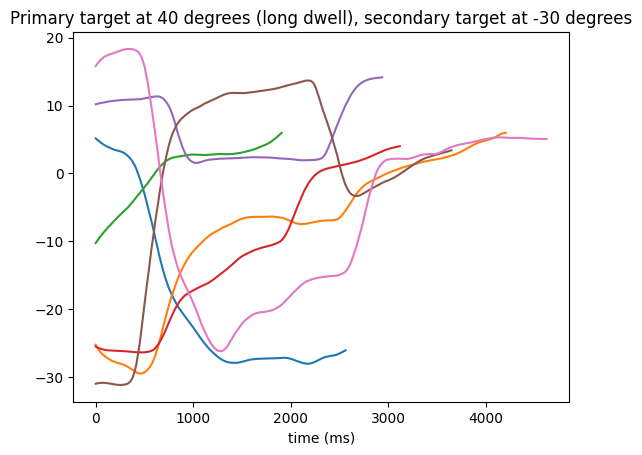

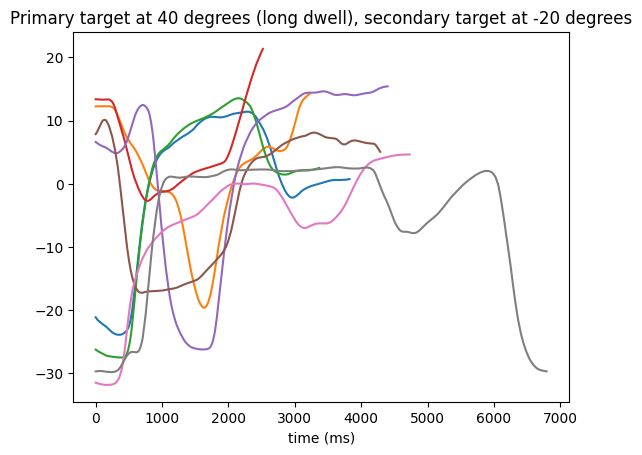

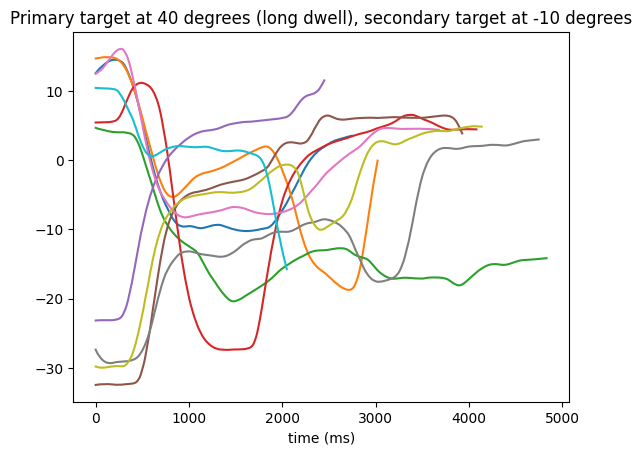

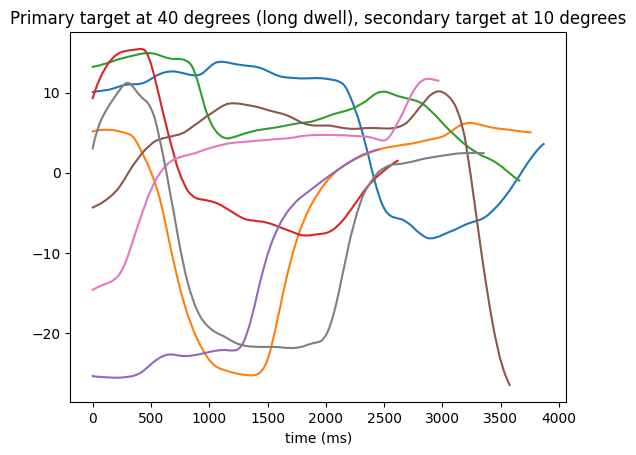

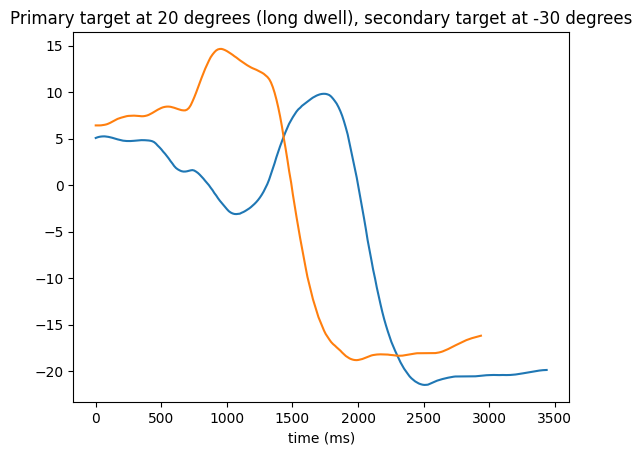

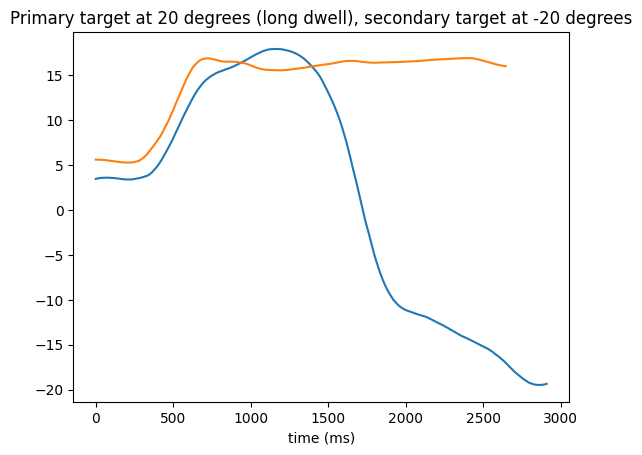

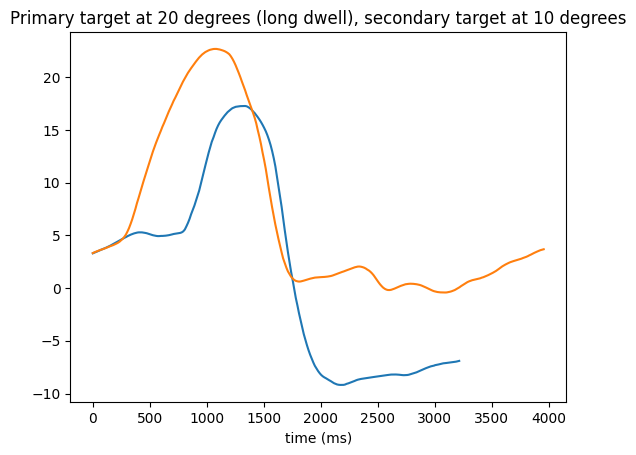

In [294]:
for cp in range(0, len(input_dirs)):
    start_end_tuples = []
    # the data with the conditions
    head_dir = all_head_data_rapid_dir_change[cp]
    eye_dir = all_eye_data_rapid_dir_change[cp]
    target_pos = all_target_data_rapid_dir_change[cp]
    target_dir = np.zeros(target_pos.shape)
    target_dir[:, 0] = target_pos[:, 0]
    for i in range(target_pos.shape[0]):
        # get the object rotation from scipy
        vec = target_pos[i, 1:]
        vec = vec / np.linalg.norm(vec)
        rot_y = np.sign(vec[0]) * (90 - np.arctan(abs(vec[2])/abs(vec[0])) * 180 / np.pi)
        # print(rot_y, target_dir[i, 2])
        target_dir[i, 2] = -rot_y


    target_input = all_target_input_rapid_dir_change[cp]
    target_fixation_angles, target_fixation_duration, fixation_angles, head_fixation_angles, target_present_duration = get_angle_per_instance(head_dir, eye_dir, target_pos, target_input, True)
    target_intervals = get_interval_per_instance(head_dir, eye_dir, target_pos, target_input, True)
    dict_20_degree_onward_angle2trial_index_short_dwell = {}
    dict_40_degree_onward_angle2trial_index_short_dwell = {}
    dict_20_degree_onward_angle2trial_index_long_dwell = {}
    dict_40_degree_onward_angle2trial_index_long_dwell = {}
    
    for i in range(0, int(fixation_angles.shape[0] / 3)):
        if target_fixation_angles[3*i+2] == 0:
            continue
        if target_present_duration[3*i+1] < 0.2:
            if np.abs(fixation_angles[3*i+1] - 20) <= 1E-3:
                try:
                    dict_20_degree_onward_angle2trial_index_short_dwell[int(np.round(target_fixation_angles[3*i+2]))].append(i)
                except:
                    dict_20_degree_onward_angle2trial_index_short_dwell[int(np.round(target_fixation_angles[3*i+2]))] = [i]
            else:
                try:
                    dict_40_degree_onward_angle2trial_index_short_dwell[int(np.round(target_fixation_angles[3*i+2]))].append(i)
                except:
                    dict_40_degree_onward_angle2trial_index_short_dwell[int(np.round(target_fixation_angles[3*i+2]))] = [i]
        elif target_present_duration[3*i+1] >= 0.2:
            if np.abs(fixation_angles[3*i+1] - 20) <= 1E-3:
                try:
                    dict_20_degree_onward_angle2trial_index_long_dwell[int(np.round(target_fixation_angles[3*i+2]))].append(i)
                except:
                    dict_20_degree_onward_angle2trial_index_long_dwell[int(np.round(target_fixation_angles[3*i+2]))] = [i]
            else:
                try:
                    dict_40_degree_onward_angle2trial_index_long_dwell[int(np.round(target_fixation_angles[3*i+2]))].append(i)
                except:
                    dict_40_degree_onward_angle2trial_index_long_dwell[int(np.round(target_fixation_angles[3*i+2]))] = [i]
    
    # compare the aboslute curvature value of the curve
    
    dict_40_degree_onward_angle_2_curvature_short_dwell = {}
    dict_20_degree_onward_angle_2_curvature_short_dwell = {}
    dict_40_degree_onward_angle_2_curvature_long_dwell = {}
    dict_20_degree_onward_angle_2_curvature_long_dwell = {}

    # vel_threshold = 0.005
    vel_threshold = 0 
    for i in sorted(dict_40_degree_onward_angle2trial_index_short_dwell.keys()): # for each secondary target angle
        indices = dict_40_degree_onward_angle2trial_index_short_dwell[i] # get the indices of the trials
        for index in indices: 
            # the trajectory of that one trial
            head_traj = head_dir[target_intervals[3*index+1][0]:target_intervals[3*index+2][1]][:, 2]
            vel = np.diff(head_traj, axis=0, prepend=head_traj[0])
            # high accelerating indicates sharp turns in the trajectory
            acc = np.abs(np.diff(vel, axis=0, prepend=vel[0]))
            acc = acc[np.where(np.abs(vel) >= vel_threshold, True, False)]
            avg_acc = np.sum(acc)/acc.shape[0]
            try:
                dict_40_degree_onward_angle_2_curvature_short_dwell[i].append(avg_acc)
            except:
                dict_40_degree_onward_angle_2_curvature_short_dwell[i] = [avg_acc]
    for i in sorted(dict_20_degree_onward_angle2trial_index_short_dwell.keys()): # for each secondary target angle
        indices = dict_20_degree_onward_angle2trial_index_short_dwell[i] # get the indices of the trials
        for index in indices:
            # the trajectory of that one trial
            head_traj = head_dir[target_intervals[3*index+1][0]:target_intervals[3*index+2][1]][:, 2]
            vel = np.diff(head_traj, axis=0, prepend=head_traj[0])
            # high accelerating indicates sharp turns in the trajectory
            acc = np.abs(np.diff(vel, axis=0, prepend=vel[0]))
            acc = acc[np.where(np.abs(vel) >= vel_threshold, True, False)]
            # when computing the mean, only consider the values where the velocity is above 0.1
            avg_acc = np.sum(acc)/acc.shape[0]
            try:
                dict_20_degree_onward_angle_2_curvature_short_dwell[i].append(avg_acc)
            except:
                dict_20_degree_onward_angle_2_curvature_short_dwell[i] = [avg_acc]
    for i in sorted(dict_40_degree_onward_angle2trial_index_long_dwell.keys()): # for each secondary target angle
        indices = dict_40_degree_onward_angle2trial_index_long_dwell[i] # get the indices of the trials
        for index in indices:
            # the trajectory of that one trial
            head_traj = head_dir[target_intervals[3*index+1][0]:target_intervals[3*index+2][1]][:, 2]
            vel = np.diff(head_traj, axis=0, prepend=head_traj[0])
            # high accelerating indicates sharp turns in the trajectory
            acc = np.abs(np.diff(vel, axis=0, prepend=vel[0]))
            acc = acc[np.where(np.abs(vel) >= vel_threshold, True, False)]
            avg_acc = np.sum(acc)/acc.shape[0]
            try:
                dict_40_degree_onward_angle_2_curvature_long_dwell[i].append(avg_acc)
            except:
                dict_40_degree_onward_angle_2_curvature_long_dwell[i] = [avg_acc]
    for i in sorted(dict_20_degree_onward_angle2trial_index_long_dwell.keys()): # for each secondary target angle
        indices = dict_20_degree_onward_angle2trial_index_long_dwell[i] # get the indices of the trials
        for index in indices:
            # the trajectory of that one trial
            head_traj = head_dir[target_intervals[3*index+1][0]:target_intervals[3*index+2][1]][:, 2]
            vel = np.diff(head_traj, axis=0, prepend=head_traj[0])
            # high accelerating indicates sharp turns in the trajectory
            acc = np.abs(np.diff(vel, axis=0, prepend=vel[0]))
            acc = acc[np.where(np.abs(vel) >= vel_threshold, True, False)]
            avg_acc = np.sum(acc)/acc.shape[0]
            try:
                dict_20_degree_onward_angle_2_curvature_long_dwell[i].append(avg_acc)
            except:
                dict_20_degree_onward_angle_2_curvature_long_dwell[i] = [avg_acc]
    # plot the average curvature for each angle as a series of blox plots
    plot_curvature_box_plot = False
    if plot_curvature_box_plot:
        plt.figure(figsize=(10, 6))
        # increase the distance between subplots
        plt.subplots_adjust(hspace=0.5)
        plt.subplot(2, 2, 1)
        plt.title("Short dwell, 40 degree primary")
        for i in sorted(dict_40_degree_onward_angle_2_curvature_short_dwell.keys()):
            plt.boxplot(dict_40_degree_onward_angle_2_curvature_short_dwell[i], positions=[i], widths=0.5)
        plt.xlabel("Secondary target angle")
        plt.ylabel("Average acceleration of trajectory")
        plt.subplot(2, 2, 2)
        plt.title("Short dwell, 20 degree primary")
        for i in sorted(dict_20_degree_onward_angle_2_curvature_short_dwell.keys()):
            plt.boxplot(dict_20_degree_onward_angle_2_curvature_short_dwell[i], positions=[i], widths=0.5)
        plt.xlabel("Secondary target angle")
        plt.ylabel("Average acceleration of trajectory")
        plt.subplot(2, 2, 3)
        plt.title("Long dwell, 40 degree primary")
        for i in sorted(dict_40_degree_onward_angle_2_curvature_long_dwell.keys()):
            plt.boxplot(dict_40_degree_onward_angle_2_curvature_long_dwell[i], positions=[i], widths=0.5)
        plt.xlabel("Secondary target angle")
        plt.ylabel("Average acceleration of trajectory")
        plt.subplot(2, 2, 4)
        plt.title("Long dwell, 20 degree primary")
        for i in sorted(dict_20_degree_onward_angle_2_curvature_long_dwell.keys()):
            plt.boxplot(dict_20_degree_onward_angle_2_curvature_long_dwell[i], positions=[i], widths=0.5)
        plt.xlabel("Secondary target angle")
        plt.ylabel("Average acceleration of trajectory")
        plt.show()

    # plot the average of average curvature for each angle as a series scatter plots
    plot_curvature_scatter_plot = False
    if plot_curvature_scatter_plot:
        # size of the plot
        plt.figure(figsize=(10, 6))
        # increase the distance between subplots
        plt.subplots_adjust(hspace=0.5)
        plt.subplot(2, 2, 1)
        plt.title("Short dwell, 40 degree primary")
        x_arr = []
        y_arr = []
        for i in sorted(dict_40_degree_onward_angle_2_curvature_short_dwell.keys()):
            plt.scatter([i], [np.mean(dict_40_degree_onward_angle_2_curvature_short_dwell[i])], color="green")
            x_arr.append(i)
            y_arr.append(np.mean(dict_40_degree_onward_angle_2_curvature_short_dwell[i]))
        # show the point of the primary target
        plt.scatter([-40], [y_arr[-1]], color="red", label="primary target")
        # add a line that go through all the points
        plt.plot(x_arr, y_arr, color="blue")
        plt.xlabel("Secondary target angle")
        plt.ylabel("Average acceleration per trial")
        plt.legend()
        plt.subplot(2, 2, 2)
        plt.title("Short dwell, 20 degree primary")
        x_arr = []
        y_arr = []
        for i in sorted(dict_20_degree_onward_angle_2_curvature_short_dwell.keys()):
            plt.scatter([i], [np.mean(dict_20_degree_onward_angle_2_curvature_short_dwell[i])], color="green")
            x_arr.append(i)
            y_arr.append(np.mean(dict_20_degree_onward_angle_2_curvature_short_dwell[i]))
        plt.scatter([20], [y_arr[0]], color="red", label="primary target")
        # add a line that go through all the points
        plt.plot(x_arr, y_arr, color="blue")
        plt.xlabel("Secondary target angle")
        plt.ylabel("Average acceleration per trial")
        plt.legend()
        plt.subplot(2, 2, 3)
        x_arr = []
        y_arr = []
        plt.title("Long dwell, 40 degree primary")
        for i in sorted(dict_40_degree_onward_angle_2_curvature_long_dwell.keys()):
            plt.scatter([i], [np.mean(dict_40_degree_onward_angle_2_curvature_long_dwell[i])], color="green")
            x_arr.append(i)
            y_arr.append(np.mean(dict_40_degree_onward_angle_2_curvature_long_dwell[i]))
        plt.scatter([-40], [y_arr[-1]], color="red", label="primary target")
        # add a line that go through all the points
        plt.plot(x_arr, y_arr, color="blue")
        plt.xlabel("Secondary target angle")
        plt.ylabel("Average acceleration per trial")
        plt.legend()
        plt.subplot(2, 2, 4)
        x_arr = []
        y_arr = []
        plt.title("Long dwell, 20 degree primary")
        for i in sorted(dict_20_degree_onward_angle_2_curvature_long_dwell.keys()):
            plt.scatter([i], [np.mean(dict_20_degree_onward_angle_2_curvature_long_dwell[i])], color="green")
            x_arr.append(i)
            y_arr.append(np.mean(dict_20_degree_onward_angle_2_curvature_long_dwell[i]))
        plt.scatter([20], [y_arr[0]], color="red", label="primary target")
        # add a line that go through all the points
        plt.plot(x_arr, y_arr, color="blue")
        plt.xlabel("Secondary target angle")
        plt.ylabel("Average acceleration per trial")
        plt.legend()
        plt.show()

    plotting_trajectory = True
    long_dwell = True
    # plot the head trajectories for each trial with a long duration
    if long_dwell and plotting_trajectory:
        for i in sorted(dict_40_degree_onward_angle2trial_index_long_dwell.keys()):
            indices = dict_40_degree_onward_angle2trial_index_long_dwell[i]
            for index in indices:
                time_arr = head_dir[target_intervals[3*index+1][0]:target_intervals[3*index+2][1]][:, 0]
                time_arr = (time_arr - time_arr[0]) * 1000
                plt.plot(time_arr, head_dir[target_intervals[3*index+1][0]:target_intervals[3*index+2][1]][:, 2:3], label="head")
                # plt.plot(time_arr, eye_dir[target_intervals[3*i+1][0]:target_intervals[3*i+2][1]][:, 2:3] + head_dir[target_intervals[3*i+1][0]:target_intervals[3*i+2][1]][:, 2:3], label="eye")
                # plt.plot(time_arr, target_dir[target_intervals[3*index+1][0]:target_intervals[3*index+2][1]][:, 2:3], label="target")
                # show the moment the eye fixates on the target as a dot
                plt.xlabel("time (ms)")
                plt.title("Primary target at 40 degrees (long dwell), secondary target at " + str(i) + " degrees")
            plt.show()
        for i in sorted(dict_20_degree_onward_angle2trial_index_long_dwell.keys()):
            indices = dict_20_degree_onward_angle2trial_index_long_dwell[i]
            for index in indices:
                time_arr = head_dir[target_intervals[3*index+1][0]:target_intervals[3*index+2][1]][:, 0]
                time_arr = (time_arr - time_arr[0]) * 1000
                plt.plot(time_arr, head_dir[target_intervals[3*index+1][0]:target_intervals[3*index+2][1]][:, 2:3], label="head")
                # plt.plot(time_arr, eye_dir[target_intervals[3*i+1][0]:target_intervals[3*i+2][1]][:, 2:3] + head_dir[target_intervals[3*i+1][0]:target_intervals[3*i+2][1]][:, 2:3], label="eye")
                # plt.plot(time_arr, target_dir[target_intervals[3*index+1][0]:target_intervals[3*index+2][1]][:, 2:3], label="target")
                # show the moment the eye fixates on the target as a dot
                plt.xlabel("time (ms)")
                plt.title("Primary target at 20 degrees (long dwell), secondary target at " + str(i) + " degrees")
            plt.show()
    elif plotting_trajectory and not long_dwell:
        for i in sorted(dict_40_degree_onward_angle2trial_index_long_dwell.keys()):
            indices = dict_40_degree_onward_angle2trial_index_long_dwell[i]
            for index in indices:
                time_arr = head_dir[target_intervals[3*index+1][0]:target_intervals[3*index+2][1]][:, 0]
                time_arr = (time_arr - time_arr[0]) * 1000
                plt.plot(time_arr, head_dir[target_intervals[3*index+1][0]:target_intervals[3*index+2][1]][:, 2:3], label="head")
                # plt.plot(time_arr, eye_dir[target_intervals[3*i+1][0]:target_intervals[3*i+2][1]][:, 2:3] + head_dir[target_intervals[3*i+1][0]:target_intervals[3*i+2][1]][:, 2:3], label="eye")
                # plt.plot(time_arr, target_dir[target_intervals[3*index+1][0]:target_intervals[3*index+2][1]][:, 2:3], label="target")
                # show the moment the eye fixates on the target as a dot
                plt.xlabel("time (ms)")
                plt.title("Primary target at 40 degrees (long dwell), secondary target at " + str(i) + " degrees")
            plt.show()
        for i in sorted(dict_20_degree_onward_angle2trial_index_long_dwell.keys()):
            indices = dict_20_degree_onward_angle2trial_index_long_dwell[i]
            for index in indices:
                time_arr = head_dir[target_intervals[3*index+1][0]:target_intervals[3*index+2][1]][:, 0]
                time_arr = (time_arr - time_arr[0]) * 1000
                plt.plot(time_arr, head_dir[target_intervals[3*index+1][0]:target_intervals[3*index+2][1]][:, 2:3], label="head")
                # plt.plot(time_arr, eye_dir[target_intervals[3*i+1][0]:target_intervals[3*i+2][1]][:, 2:3] + head_dir[target_intervals[3*i+1][0]:target_intervals[3*i+2][1]][:, 2:3], label="eye")
                # plt.plot(time_arr, target_dir[target_intervals[3*index+1][0]:target_intervals[3*index+2][1]][:, 2:3], label="target")
                # show the moment the eye fixates on the target as a dot
                plt.xlabel("time (ms)")
                plt.title("Primary target at 20 degrees (long dwell), secondary target at " + str(i) + " degrees")
            plt.show()
    print("===========================================")
            
